## 1. Motivation

For our first dataset, we chose London's public bike-sharing data from Santander Cycles, which consists of the number of bicycle hires per day from 2010 to 2022. We wanted to analyze the effects of the weather on the rentals, so we chose a dataset containing data about, for example, wind speed, visibility, air temperature or humidity from 2010 till 2020. Our third one is about COVID-19 in London (2019-2021), which includes COVID-19 cases and the age of infected people. We used the Transport of London data base of the shared bikes (Santander Cycles) in London for the bicycle trips, consisting of the duration of the rent, bike id, and start and end stations' ids and names. To visualize the trips, we added a dataset of the bike stations so that we can add longitude and latitude. The last dataset we used was a routing dataset requested from the Here Api to get the trip's course, length, and duration.

In cities worldwide, bicycles are recognized as a reasonable and practical part of the transportation system. Bicycles improve health, ease congestion, save money, use less space, and provide efficient transportation with zero fuel consumption and zero carbon emissions. We wanted to analyze bike hiring behavior in London based on mentioned data over the years and make predictions. We chose London due to its vast public data availability.

Our goal was to analyze what affects bike rental numbers (lousy weather, pandemic) and then predict what is to be expected in the future. Can London become a greener city? We also wanted to see which stations and routes are used the most to get insight into people's interests.

# Package Imports

In [440]:
# standard packages
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime as dt

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
import folium
from folium import plugins
from bokeh.models import HoverTool, Line
from bokeh.models.tools import CustomJSHover
from bokeh.plotting import figure, output_file, show, output_notebook
output_notebook()

# packages to process geodata
from shapely.geometry import Point, Polygon
import fiona # fiona needs to be imported before geopandas (otherwise gdp does not work properly)
import geopandas as gpd
import json

# packages to access the here api
from here_location_services import LS
from here_location_services.config.routing_config import ROUTING_RETURN
from here_map_widget import Map, Marker, GeoJSON

# packages for the machine learning part
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from torch import nn

# clearer outputs
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Loading BokehJS ...

## 2. Basic stats

We divided the dataset into three new ones for the bike hiring dataset due to cleaning the one we used, and then we dropped all rows with NaN values. The weather dataset was messy and contained much data we did not need for our analysis, so it needed much cleaning. We removed the rows that contained zeros and columns that were not relevant as ids and method and manner of measurement, and at the end, we merged the dataset with the bike hiring one. For the COVID-19 dataset, we removed columns "area_code" and "area_name" due to all cases being in London. We converted column "date" to dataframe, removed rows that contained NaN values, and merged the dataset with the bike rental dataset. We merged the bike movements and bike stations to have one dataset with all relevant data for the analysis. As for the routing dataset, we extracted the length and duration of trips from the "summary" column, added the "datetime" column with values from the "Start Date" column from the bike movements dataset, and converted the values to datetime. In the end, we merged the datasets.

We have mainly considered 3 datasets. 
-	Bike rentals data (2010 – 2022)
-	Covid data (2020 – 2022)
-	Weather data (2010 – 2019)
-	TFL Bike Trips

All 3 of these data sources are updated with the previous day's information. Each data point is a day, and the data points span from their starting year to their finishing year. These datasets can be described as: *insert .describe() in the notebook*. An exception is the covid data, which has more data points for each day (binned for age groups)
In the exploratory analysis, all the data followed a seasonal pattern, but more on that in subsequent parts of the report.  


# Data Imports

In [398]:
# bike rental numbers (https://data.london.gov.uk/dataset/number-bicycle-hires)
# metadata = pd.read_excel(Path.cwd().parent/"files"/"tfl-daily-cycle-hires.xlsx")
bike_rentals = pd.read_excel(Path.cwd().parent/"files"/"Assignment3"/"bike_rentals_london.xlsx", sheet_name = 'Data')

In [ ]:
# covid cases (https://data.london.gov.uk/dataset/coronavirus--covid-19--cases)
covid = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/"corona_london.csv")

### weather
# weather (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1)
# metadata od the weather data (https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WH_Table.html)
li = []

for i in range(2010,2020,1):

    dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)
    li.append(dummy)

weather = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
# importing trips of shared bikes (Santander Cycles) in London 
# source: https://cycling.data.tfl.gov.uk/ (tfl = Transport for London)
cycling_load = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"cycling-load.json"))

dfs = []

# use for loop in comment below if you want all the data -> download roughly 30 min
# for counter, url in enumerate(cycling_load['entries']):

# the loop downloads the data from TFL via the urls provided in cycling_load

for i in range(1):

    bike_movements = pd.read_csv(cycling_load['entries'][i]['url'])
    dfs.append(bike_movements)

bike_movements = pd.concat(dfs)

bike_movements.head()

In [ ]:
# importing stations of shared bikes (Santander Cycles) in London to get their location
# source: https://api-portal.tfl.gov.uk/api-details#api=BikePoint&operation=BikePoint_GetAll

bike_stations = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"bikepoint.json"))

# Pre-Processing and Merging the Weather and Covid Data with the Rental Numbers, respectively

In [399]:
# preprocessing the bike rental numbers

bike_rentals_month = bike_rentals[['Month', 'Number of Bicycle Hires.1', 'Average Hire Time (mins)']]
# drop NaN rows
bike_rentals_month = bike_rentals_month[bike_rentals_month['Number of Bicycle Hires.1'].notna()]

bike_rentals_year = bike_rentals[['Year', 'Number of Bicycle Hires.2']]
bike_rentals_year = bike_rentals_year.iloc[:bike_rentals_year.Year.isnull().values.argmax()]

bike_rentals = bike_rentals.drop(columns = ['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8', 'Month.1', 'Month', 'Number of Bicycle Hires.1', \
    'Average Hire Time (mins)', 'Year', 'Number of Bicycle Hires.2'])

print(bike_rentals.describe())
bike_rentals.head()

       Number of Bicycle Hires
count              4204.000000
mean              26320.135347
std                9693.146364
min                2764.000000
25%               19271.000000
50%               26145.500000
75%               33371.000000
max               73094.000000


Day  Number of Bicycle Hires
0 2010-07-30                     6897
1 2010-07-31                     5564
2 2010-08-01                     4303
3 2010-08-02                     6642
4 2010-08-03                     7966

<AxesSubplot:xlabel='Day', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

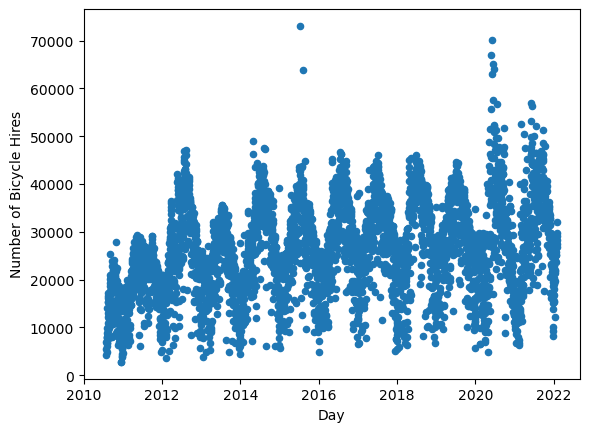

In [400]:
# Chronological Scatter Plot of the Rental Numbers

plt.figure(figsize=(30, 75))
bike_rentals.plot.scatter(x='Day', y='Number of Bicycle Hires')

In [401]:
# Preprocessing weather data

# drop columns with only NaNs
weather = weather.dropna(axis=1, how='all')
# drop rows with only NaNs
weather = weather.dropna(axis=0, how='all')
# drop columns version_num as all values = 1.0, id as all values = 3772, met_domain_name as all values = SYNOP,
# id_type = WMO , 'src_id' = 708
weather = weather.drop(columns = ['version_num', 'id', 'met_domain_name', 'id_type', 'src_id'])
# drop rows where ob_time == 'end data' as all other rows are NaN
weather = weather.drop(weather[weather.ob_time == 'end data'].index)
# drop column wind_speed_unit_id as all values = 4
weather = weather.drop(columns = ['wind_speed_unit_id'])
# drop columns as the method and manner of measurement are not relevant for this analysis
weather = weather.drop(columns = ['rec_st_ind', 'src_opr_type', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'dewpoint_j', \
    'wetb_temp_j', 'rltv_hum_j', 'midas_stmp_etime', 'meto_stmp_time', 'prst_wx_id'])
# quality control out of the scope of the project -> drop all columns
weather = weather.drop(columns = ['wind_direction_q', 'wind_speed_q', 'prst_wx_id_q', 'cld_ttl_amt_id_q', 'cld_base_ht_q',\
    'visibility_q', 'msl_pressure_q', 'cld_amt_id_1_q', 'cld_base_ht_id_1_q', 'cld_amt_id_2_q', 'cld_base_ht_id_2_q', 'cld_amt_id_3_q',\
    'cld_base_ht_id_3_q', 'stn_pres_q', 'alt_pres_q', 'q10mnt_mxgst_spd_q', 'wmo_hr_sun_dur_q', 'snow_depth_q', 'drv_hr_sun_dur',\
    'drv_hr_sun_dur_q'])
# drop columns not necessary for analysis
weather = weather.drop(columns = ['alt_pres', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3',\
    'cld_base_ht_id_3', 'q10mnt_mxgst_spd', 'snow_depth', 'cavok_flag'])

# drop rows where air_temperature or wind_speed = NaN
weather = weather[weather['air_temperature'].notna()]
weather = weather[weather['wind_speed'].notna()]
# converting date to datetime
weather['ob_time'] = pd.to_datetime(weather['ob_time'])
# group by day to be able to merge it with the bike rental data
weather = weather.groupby(weather['ob_time'].dt.date).mean().reset_index()
weather['ob_time'] = pd.to_datetime(weather['ob_time'])

## optional
# drop rows where cld_ttl_amt_id, cld_base_ht, visibility, wmo_hr_sun_dur depending on analysis
# weather = weather[weather['cld_ttl_amt_id'].notna()]
# weather = weather[weather['cld_base_ht'].notna()]
# weather = weather[weather['visibility'].notna()]
# weather = weather[weather['wmo_hr_sun_dur'].notna()]

## checks
# NaN check 
print(weather.isna().sum())

## Preprocessing combing bike rentals and weather data by joining on the datetime
# dropping ob_time as similar to Day

bike_rentals_weather = pd.merge(bike_rentals, weather, left_on='Day', right_on='ob_time')
bike_rentals_weather = bike_rentals_weather.drop(columns=['ob_time'])
print(bike_rentals_weather.describe().T)
bike_rentals_weather.head()

ob_time             0
wind_direction      0
wind_speed          0
cld_ttl_amt_id     43
cld_base_ht        43
visibility          2
msl_pressure        0
air_temperature     0
dewpoint            0
wetb_temp           0
rltv_hum            0
stn_pres            0
wmo_hr_sun_dur     10
dtype: int64
                          count          mean          std          min           25%           50%           75%           max
Number of Bicycle Hires  3430.0  25700.722157  9227.871616  2764.000000  19143.750000  25616.000000  32544.500000  73094.000000
wind_direction           3430.0    195.499024    72.062422    18.750000    148.854167    212.916667    247.916667    352.500000
wind_speed               3430.0      8.028507     3.329078     1.541667      5.541667      7.458333      9.875000     23.416667
cld_ttl_amt_id           3387.0      4.808249     2.331597     0.000000      3.083333      5.208333      6.833333      8.291667
cld_base_ht              3387.0    138.152566    62.576971   

Day  Number of Bicycle Hires  wind_direction  wind_speed  cld_ttl_amt_id  cld_base_ht   visibility  msl_pressure  air_temperature   dewpoint  wetb_temp   rltv_hum     stn_pres  wmo_hr_sun_dur
0 2010-07-30                     6897      267.500000    6.791667        5.500000   123.750000  1883.333333   1014.687500        17.558333  10.479167  13.741667  64.450000  1011.712500        0.130435
1 2010-07-31                     5564      240.000000    9.333333        5.291667   102.083333  2919.583333   1011.554167        19.858333  13.708333  16.358333  69.808333  1008.612500        0.204348
2 2010-08-01                     4303      261.250000    5.916667        7.208333   156.666667  2879.166667   1013.225000        18.795833  11.125000  14.591667  62.675000  1010.266667        0.017391
3 2010-08-02                     6642      247.083333    4.708333        6.500000   173.333333  2470.833333   1016.791667        18.837500  10.483333  14.304167  59.066667  1013.833333        0.091304
4 2010-08-03                     7966      256.666667    6.750000        4.666667   177.083333  1908.333333   1015.687500        17.870833  11.225000  14.225000  66.145833  1012.729167        0.169565

<AxesSubplot:xlabel='air_temperature', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

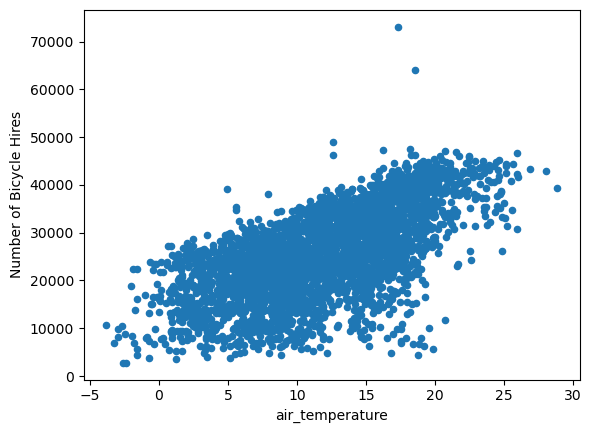

In [402]:
# creating a scatter plot of the rental numbers against the air temperature

plt.figure(figsize=(30, 75))
bike_rentals_weather.plot.scatter(x='air_temperature', y='Number of Bicycle Hires')

The above plot shows that more people rent bikes with higher air temperature. The second figure presents how humidity affects the number of bike hires, the lower the humidity level, the higher bike rentals. 

<AxesSubplot:xlabel='rltv_hum', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

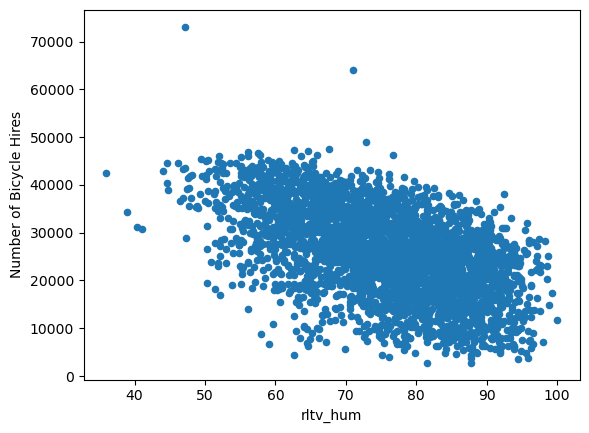

In [403]:
# creating a scatter plot of the rental numbers against the relative humidity

plt.figure(figsize=(30, 75))
bike_rentals_weather.plot.scatter(x='rltv_hum', y='Number of Bicycle Hires')

In [404]:
# Preprocessing covid data

# drop all dates without age information
covid = covid[covid.age_band != 'unassigned']
# drop columns area_name, area_code
covid = covid.drop(columns = ['area_name', 'area_code'])
# converting date to datetime
covid['date'] = pd.to_datetime(covid['date'])

## checks
# NaN check 
print(covid.isna().sum())

# Preprocessing combing bike rentals and covid data by joining on the datetime
# drop date as similar to Day

bike_rentals_covid = pd.merge(bike_rentals, covid, left_on='Day', right_on='date')
bike_rentals_covid = bike_rentals_covid.drop(columns=['date'])
print(bike_rentals_covid.describe().T)
bike_rentals_covid.head()

date            0
cases           0
rolling_sum     0
rolling_rate    0
age_band        0
age_lower       0
age_higher      0
population      0
dtype: int64
                           count           mean            std      min        25%       50%       75%       max
Number of Bicycle Hires  13851.0   29324.755830   11259.519725   4872.0   21173.00   29221.0   37527.0   70170.0
cases                    13851.0     173.198397     408.984842      0.0       6.00      32.0     165.0    6834.0
rolling_sum              13851.0    1196.396072    2734.724978      0.0      40.00     225.0    1160.0   37363.0
rolling_rate             13851.0     223.188434     423.082395      0.0      12.95      68.2     232.7    4930.1
age_lower                13851.0      45.000000      27.387117      0.0      20.00      45.0      70.0      90.0
age_higher               13851.0      48.789474      27.053711      4.0      24.00      49.0      74.0      90.0
population               13851.0  473815.157895  226

Day  Number of Bicycle Hires  cases  rolling_sum  rolling_rate       age_band  age_lower  age_higher  population
0 2020-02-03                    28267      0            0           0.0    0 - 4 years        0.0         4.0    595799.0
1 2020-02-03                    28267      0            0           0.0    5 - 9 years        5.0         9.0    606333.0
2 2020-02-03                    28267      0            0           0.0  10 - 14 years       10.0        14.0    550753.0
3 2020-02-03                    28267      0            0           0.0  15 - 19 years       15.0        19.0    474456.0
4 2020-02-03                    28267      1            0           0.0  20 - 24 years       20.0        24.0    556594.0

# 3. Data Analyis

# Covid Analysis

We decided to take a look at the COVID-19 dataset because it is interesting to explore how the data is changing due to the pandemic. After we performed the analysis we saw that we chose the right direction because it can be seen from the following plots that the pandemic really affected the number of bike rentals.

The "AgeGroup" column was created and the "age_band" one was removed. It is easier to get a better insight into the data if we have different age groups than 5-year differences between people. 

In [405]:
# further preprocessing the covid data by adding age groups

bins= [0.0,15.0,30.0,60.0,91.0]
labels = ['Child','Young Adult','Middle-Age Adult','Senior-Citizen']
bike_rentals_covid['AgeGroup'] = pd.cut(bike_rentals_covid['age_lower'], bins=bins, labels=labels, right=False)
bike_rentals_covid = bike_rentals_covid.drop(["age_band"], axis=1)
bike_rentals_covid.head()

Day  Number of Bicycle Hires  cases  rolling_sum  rolling_rate  age_lower  age_higher  population     AgeGroup
0 2020-02-03                    28267      0            0           0.0        0.0         4.0    595799.0        Child
1 2020-02-03                    28267      0            0           0.0        5.0         9.0    606333.0        Child
2 2020-02-03                    28267      0            0           0.0       10.0        14.0    550753.0        Child
3 2020-02-03                    28267      0            0           0.0       15.0        19.0    474456.0  Young Adult
4 2020-02-03                    28267      1            0           0.0       20.0        24.0    556594.0  Young Adult

<AxesSubplot:title={'center':'cases'}, xlabel='AgeGroup'>

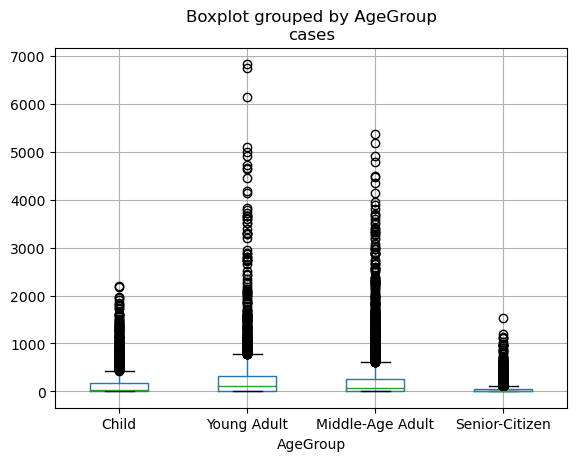

In [46]:
# using a boxplot to analyse the different age groups

bike_rentals_covid.boxplot('cases','AgeGroup')

From the above boxplots can be seen that young adults are the most infected age group, and middle-aged adults are following them. It is interesting how people between 60 and 91 years are the ones that are the least affected by the virus, that is probably because there are more younger people living in the city. We can see some outliers, but they can be explained as they are following the COVID-19 cases which are varying from day to day. The outlier detection can be seen below.

In [507]:
def find_outliers_IQR(bike_rentals_covid):
   q1=bike_rentals_covid.quantile(0.25)
   q3=bike_rentals_covid.quantile(0.75)
   IQR=q3-q1
   outliers = bike_rentals_covid[((bike_rentals_covid<(q1-1.5*IQR)) | (bike_rentals_covid>(q3+1.5*IQR)))]
   return outliers

In [508]:
outliers = find_outliers_IQR(bike_rentals_covid['cases'])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
outliers

number of outliers: 1513
max outlier value: 6834
min outlier value: 404


5325      414
5895      453
5896      458
5897      414
5898      418
         ... 
13839    1169
13840    1177
13841     867
13842     641
13843     526
Name: cases, Length: 1513, dtype: int64

The next step was to divide the "Day" column into year, months, date, and day so we can better analyze the dataset and get some conclusions. We decided to plot data based on the type of the day if it is a weekend or weekday, and by season as well.

In [407]:
# adding columns for the year, date, day, month, day of the week, weekend and season
bike_rentals_covid['year']=bike_rentals_covid.Day.dt.year
bike_rentals_covid['pickup_date']=bike_rentals_covid.Day.dt.date
bike_rentals_covid['pickup_day']=bike_rentals_covid.Day.dt.day
bike_rentals_covid['pickup_month']=bike_rentals_covid.Day.dt.month

# Extracting the day of the week (dow)
bike_rentals_covid['pickup_dow'] = pd.to_datetime(bike_rentals_covid['Day']).dt.dayofweek

# Type of day column
bike_rentals_covid['pickup_weekend'] = bike_rentals_covid.Day.dt.dayofweek.apply(lambda x: '0' if x <5 else '1')

# Adding the season
bike_rentals_covid['season']=bike_rentals_covid.Day.dt.month.apply(lambda x: 'Winter' if x <=2 else 'Spring' if x<=5 else 'Summer' 
                                             if x<=8 else 'Autumn' if x<=11 else 'Winter')

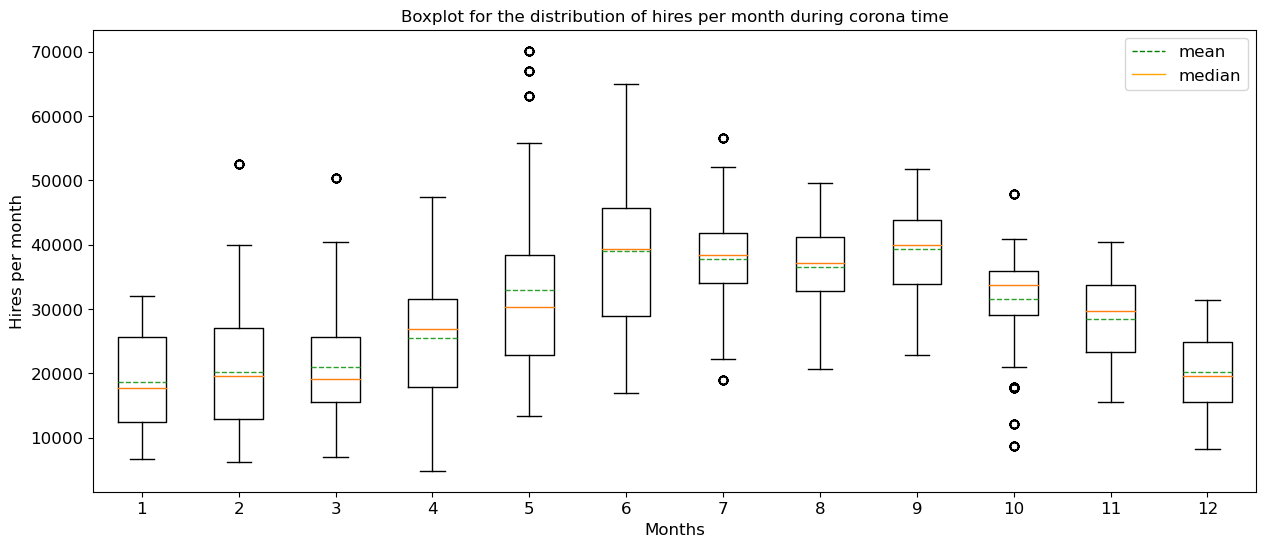

In [469]:
# creating a boxplot to analyse the different months
figure = plt.figure(figsize =(15, 6))
bikes_month=[]
for i in range(1,13):
    bikes_month.append(bike_rentals_covid[bike_rentals_covid['pickup_month']==i]['Number of Bicycle Hires'])
    #print(len(bikes[bikes['starttime_hour']==i]['pickups/hr'])) #363-365 because we remove >80 
    # Creating plot
plt.boxplot(bikes_month, showmeans=True, meanline= True)
plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='orange', label='median')
plt.xlabel("Months", fontsize=12)
plt.ylabel("Hires per month", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title("Boxplot for the distribution of hires per month during corona time")
plt.show()

First, we plotted the bicycle hires per month. The data is positively skewed in the first three months, then it becomes negatively skewed for a month, in May it gets back to being skewed right, and for the following months is skewed left. For the outliers, we assume that during the lockdowns, some people maybe did not stay at home, but went outside and to be safer hired a bike rather than went by public transport, if it was running. Regarding October, London was placed on the national coronavirus watchlist following a rise in cases at the beginning of this month 2020, so we assume that is the reason for fewer bike hires during that month.

In [438]:
# plotting the number of bicycle hires during the covid period in Bokeh
output_file('COVIDnumberOfHiresPerDay.html')
fig = figure(title = 'Bicycle hires per day during covid', x_axis_label = 'Date', y_axis_label = 'Bicycle hires', x_axis_type='datetime', plot_width=750, plot_height=400)
fig.line(bike_rentals_covid['pickup_date'],bike_rentals_covid['Number of Bicycle Hires'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('Number of Bicycle hires', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

The above visualization shows the number of bicycle hires during the COVID-19. In March 2020, the number of affected London citizens began to grow, and at the end of the month, there was a closure of the economy and the first lockdown, and therefore a fewer bike rentals. In the middle of May, the lockdown started to ease, and the bicycle hires began to rise. On 25th of September 2020, London was placed on the national coronavirus watchlist following a rise in cases. The second lockdown happened in November with rules similar to the first one, with the exception of schools and universities staying open, and it lasted for less than a month. On 8th of January 2021, London Mayor declared the COVID-19 crisis in London a "major incident" with "out of control" spread, and rentals dropped again. The lifting of restrictions began in March 2021. The last drop happened on the 18th of December 2021, when another "major incident" was declared in London by the Mayor due to the rapid rise in Omicron variant cases, leading to the largest number of daily cases recorded for the city since the pandemic began. The following plot is presenting the COVID-19 cases per day. The datasets match as much as possible, at the beginning of the pandemic there were not many cases, and until January 2021 when cases jumped, the rentals dropped, and after that period the virus was not unknown and people started to get vaccinations so the numbers of renting went up and dropped again in December 2021, due to mentioned rapid rise in Omicron variant cases. 

In [439]:
# plotting the covid cases per day in Bokeh

output_file('COVIDnumberOfCasesPerDay.html')
fig = figure(title = 'Cases per day during covid', x_axis_label = 'Date', y_axis_label = 'Bicycle hires', x_axis_type='datetime', plot_width=750, plot_height=400)
fig.line(bike_rentals_covid['pickup_date'],bike_rentals_covid['cases'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('Number of Cases', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

In [409]:
# grouping the data by day of the week and season to analyse the number of hires
covid_hires_per_season=bike_rentals_covid.groupby(['pickup_dow','season']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_season.head()

pickup_dow  season  Number of Bicycle Hires
0           0  Autumn             30097.538462
1           0  Spring             24130.703704
2           0  Summer             33763.518519
3           0  Winter             17984.000000
4           1  Autumn             33323.846154

The following plots present the pickups per type of the day, and per season. It can be seen that the most bikes were hired on Saturday and the least on Monday. We are assuming that people like to spend the weekend in the city, biking through parks and enjoying nature rather than staying at home or using public transport due to having more free time. No one likes Monday, everyone are tired from the previous week and wants the weekend to last longer, so they probably travel by public transport or car on that day. On the other weekdays, some people are travelling to work and school by bike so that is why there are more hires on that days. Moreover, winter has a very low number of rented bicycles, which makes sense due to the bad weather conditions and cold, while summer has the highest number of bike hires due to the same reasons. Autumn is the second-best season by the number of pickups because the weather in autumn is still good and the beginning of the season is the end of the summer, so it has still a high air temperature. The spring follows after winter so it is obvious why it has fewer bike rentals than autumn and summer.

In [410]:
# grouping the data by day of the week and weekend to analyse the number of hires
covid_hires_per_dow=bike_rentals_covid.groupby(['pickup_dow','pickup_weekend']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_dow.head()

pickup_dow pickup_weekend  Number of Bicycle Hires
0           0              0             26621.714286
1           1              0             28847.163462
2           2              0             28816.971154
3           3              0             28499.365385
4           4              0             29066.423077

Text(0.5, 1.0, 'Hires per season')

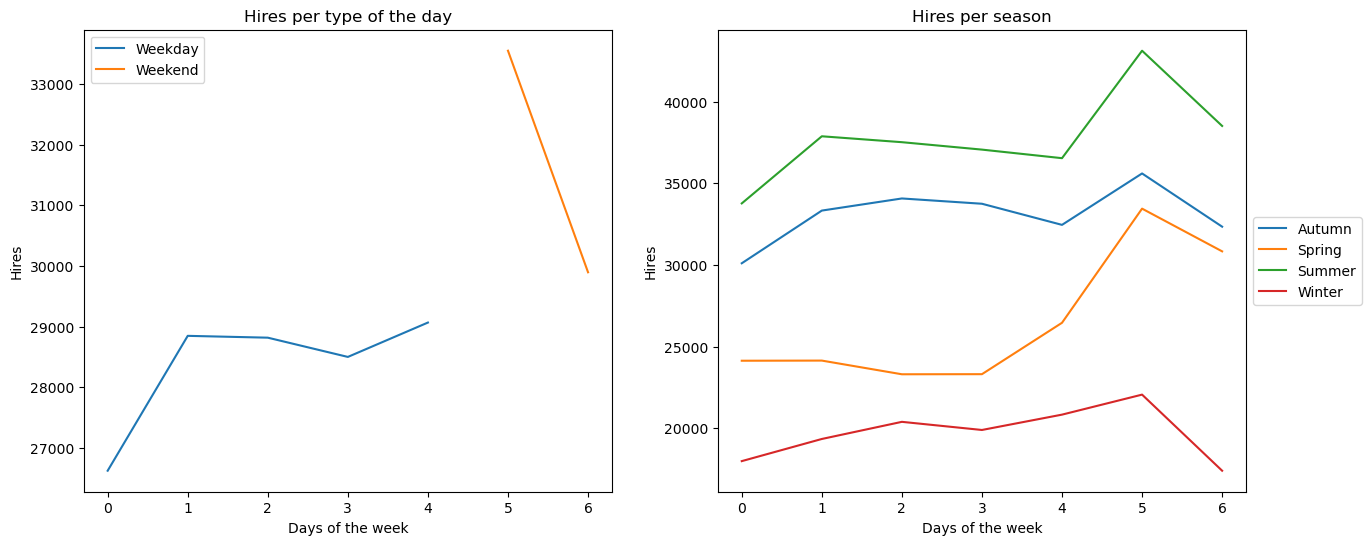

In [411]:
#Plotting pickups based on the type of the day and the season
 
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
#ax = plt.gca()
for weekday in covid_hires_per_dow['pickup_weekend'].unique():
    covid_hires_per_dow[covid_hires_per_dow.pickup_weekend==weekday].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[0],xlabel='Days of the week',ylabel='Hires')
axes[0].legend(['Weekday','Weekend'])
axes[0].set_title('Hires per type of the day')

for season in covid_hires_per_season['season'].unique():
    covid_hires_per_season[covid_hires_per_season.season==season].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[1],xlabel='Days of the week',ylabel='Hires')
axes[1].legend(covid_hires_per_season['season'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Hires per season')

In [413]:
# grouping data by day of the week and age group to analyse the covid cases
covid_cases_per_agegroup=bike_rentals_covid.groupby(['pickup_dow','AgeGroup']).mean()['cases'].reset_index()
covid_cases_per_agegroup.head()

pickup_dow          AgeGroup       cases
0           0             Child  195.355556
1           0       Young Adult  348.917460
2           0  Middle-Age Adult  300.622222
3           0    Senior-Citizen   51.619048
4           1             Child  177.163462

Text(0.5, 1.0, 'Covid-19 cases per day of the week per age group')

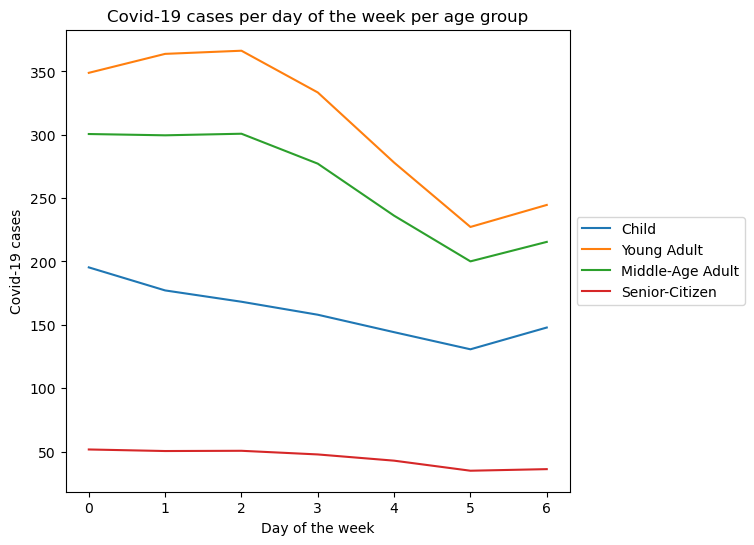

In [414]:

ax = plt.gca()
for agegroup in covid_cases_per_agegroup['AgeGroup'].unique():
    covid_cases_per_agegroup[covid_cases_per_agegroup.AgeGroup==agegroup].plot(kind='line',x='pickup_dow',y='cases',ax=ax,xlabel='Day of the week',ylabel='Covid-19 cases',figsize=(6.5,6))
plt.legend(covid_cases_per_agegroup['AgeGroup'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covid-19 cases per day of the week per age group')

Then we decided to plot the COVID-19 cases per day of the week and per age group. We can see that Tuesday and Wednesday are the days with the most, and Saturday the least infected ones. The pattern of middle-aged adults is very similar to the one of young adults, that age groups are most affected due to their everyday lives. The next visualization is the correlation matrix. From it can be seen that cases and the number of bicycle hires are negatively correlated, which means that if the cases are rising, the hires are dropping, and the other way around, as we saw in the previous visualizations as well. 

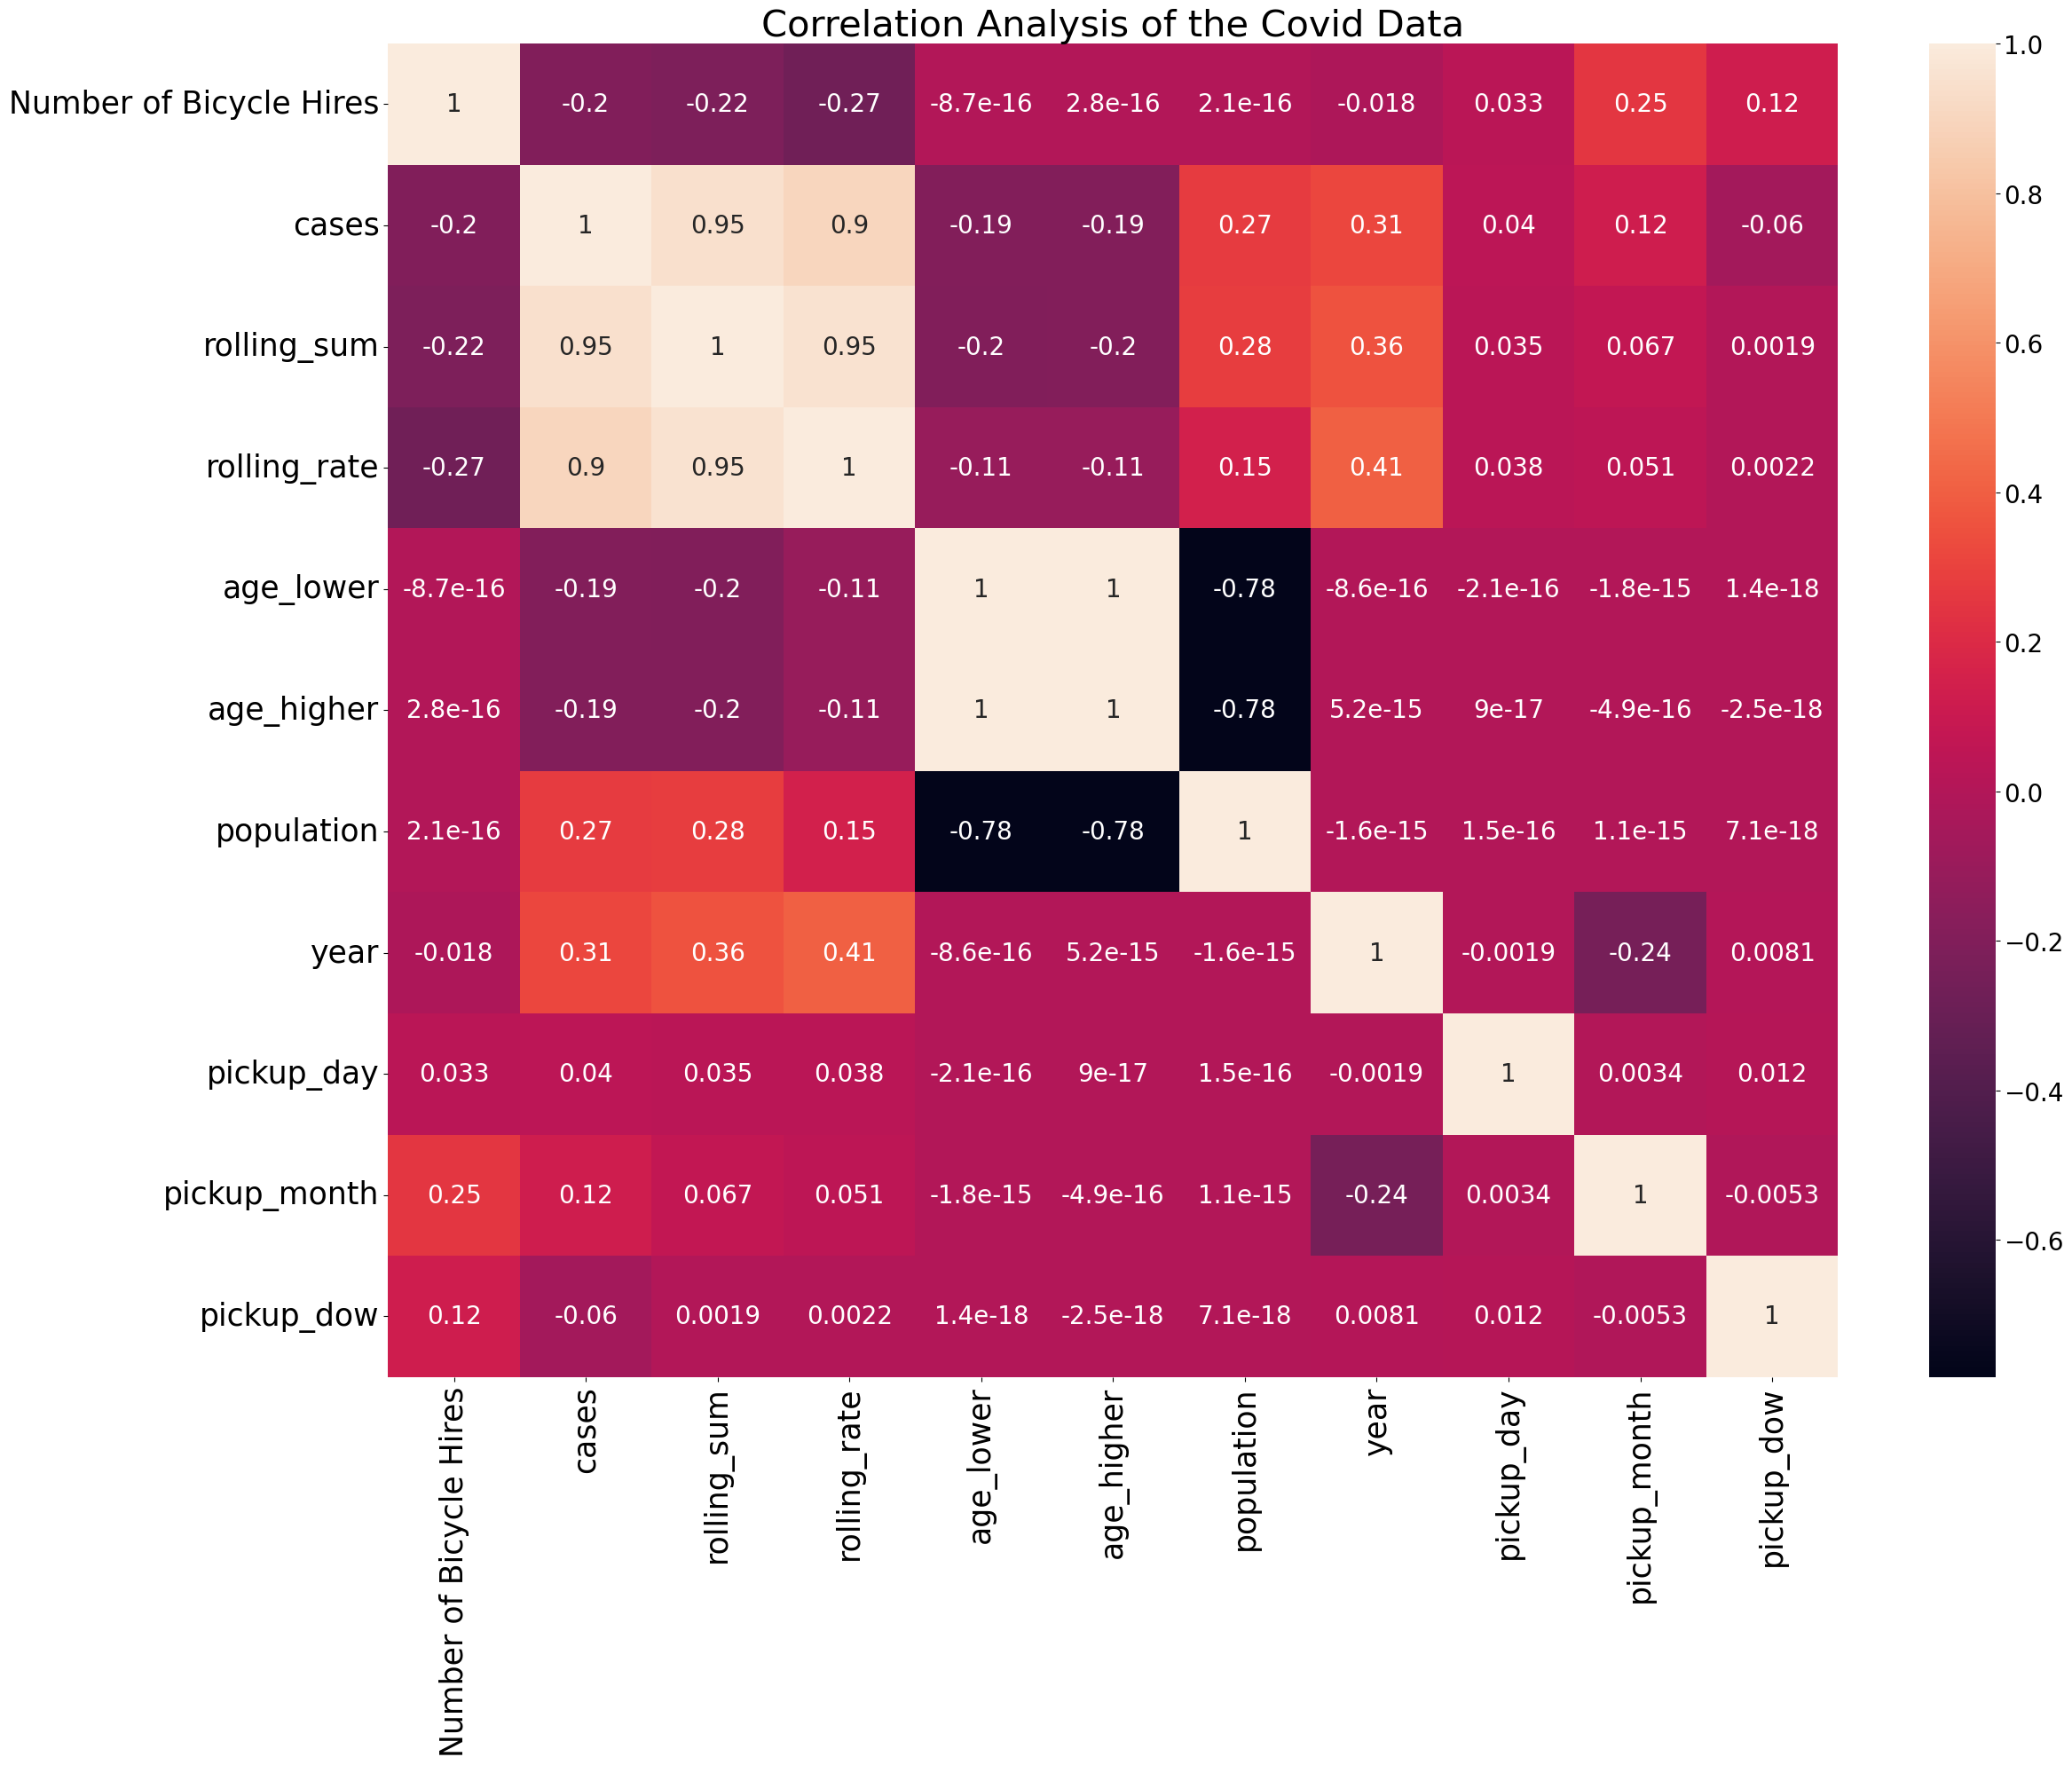

In [423]:
corrMatrix = bike_rentals_covid.corr()
plt.figure(figsize=(25, 20))
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('Correlation Analysis of the Covid Data', fontsize = 30)
plt.xticks(fontsize=25, rotation = 90)
plt.yticks(fontsize=25, rotation = 0)
plt.tight_layout()
plt.show()

# Bicycle Movements

We wanted to find the most used streets by shared bike users in London. We imported the bike trips for Transport of London and merged them with the bike stations by start and end id, respectively to get longitude and latitude of the start and end points.

In [76]:
# preprocessing the bike_stations
bike_stations = pd.DataFrame(bike_stations)
bike_stations = bike_stations.drop(['$type', 'url', 'placeType', 'additionalProperties', 'children', 'childrenUrls'], axis='columns')
bike_stations.head()

id                            commonName        lat       lon
0  BikePoints_1            River Street , Clerkenwell  51.529163 -0.109970
1  BikePoints_2        Phillimore Gardens, Kensington  51.499606 -0.197574
2  BikePoints_3  Christopher Street, Liverpool Street  51.521283 -0.084605
3  BikePoints_4       St. Chad's Street, King's Cross  51.530059 -0.120973
4  BikePoints_5         Sedding Street, Sloane Square  51.493130 -0.156876

In [77]:
# chaning the id from string to int e.g. 'BikePoints_1' -> 1
list_id = list(range(1,len(bike_stations)+1))
bike_stations['id'] = list_id
bike_stations.head()

id                            commonName        lat       lon
0   1            River Street , Clerkenwell  51.529163 -0.109970
1   2        Phillimore Gardens, Kensington  51.499606 -0.197574
2   3  Christopher Street, Liverpool Street  51.521283 -0.084605
3   4       St. Chad's Street, King's Cross  51.530059 -0.120973
4   5         Sedding Street, Sloane Square  51.493130 -0.156876

In [78]:
# combining the bike movements with the bike stations

bike_movements = pd.merge(bike_movements, bike_stations, left_on="StartStation Id", right_on="id")
bike_movements = bike_movements.rename(columns={'id': 'id_start', 'lon' : 'lon_start', 'lat' : 'lat_start'})
bike_movements = pd.merge(bike_movements, bike_stations, left_on="EndStation Id", right_on="id")
bike_movements = bike_movements.rename(columns={'id': 'id_end', 'lon' : 'lon_end', 'lat' : 'lat_end'})
# bike_movements = bike_movements.dropna()
print(bike_movements.isnull().sum())

bike_movements.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id     EndStation Name        Start Date  StartStation Id          StartStation Name  id_start                         commonName_x  lat_start  lon_start  id_end          commonName_y    lat_end   lon_end
0   50754225       240    11834  10/01/2016 00:04          383.0  Frith Street, Soho  10/01/2016 00:00               18  Drury Lane, Covent Garden        18            Drury Lane, Covent Garden  51.514770  -0.122219     383  Merchant Street, Bow  51.526578 -0.027581
1   50762493      1920     5987  10/01/2016 15:05          383.0  Frith Street, Soho  10/01/2016 14:33              717  Dunston Road , Haggerston       717            Irene Road, Parsons Green  51.473763  -0.197010     383  Merchant Street, Bow  51.526578 -0.027581
2   50858478      2460    11290  14/01/2016 18:42          383.0  Frith Street, Soho  14/01/2016 18:01              717  Dunston Road , Haggerston       717            Irene Road, Parsons Green  51.473763  -0.197010     383  Merchant Street, Bow  51.526578 -0.027581
3   50984312       720     9528  20/01/2016 18:04          383.0  Frith Street, Soho  20/01/2016 17:52              264  Tysoe Street, Clerkenwell       264  Finsbury Leisure Centre, St. Luke's  51.526008  -0.096317     383  Merchant Street, Bow  51.526578 -0.027581
4   51033373      1440    10824  22/01/2016 20:54          383.0  Frith Street, Soho  22/01/2016 20:30              264  Tysoe Street, Clerkenwell       264  Finsbury Leisure Centre, St. Luke's  51.526008  -0.096317     383  Merchant Street, Bow  51.526578 -0.027581

In [79]:
# creating a location column which contains latitude and longitude
bike_movements["location_rental_start"]=list(zip(bike_movements["lon_start"], bike_movements["lat_start"]))
bike_movements["location_rental_end"]=list(zip(bike_movements["lon_end"], bike_movements["lat_end"]))

# Caluclating how much each location is "visited" to get consumption
rental_starts = bike_movements.groupby(by=['location_rental_start']).agg({'location_rental_start':'count'}).\
    rename(columns={'location_rental_start':'count'}).reset_index()
rental_starts = gpd.GeoDataFrame(rental_starts, crs = "epsg:4326", geometry = rental_starts.location_rental_start.apply(Point))

rental_ends = bike_movements.groupby(by=['location_rental_end']).agg({'location_rental_end':'count'}).\
    rename(columns={'location_rental_end':'count'}).reset_index()
rental_ends = gpd.GeoDataFrame(rental_ends, crs = "epsg:4326", geometry = rental_ends.location_rental_end.apply(Point))

Then, we requested the trips from the Here Routing Api to visualize and analyze them. The free requests are limited to a thousand, so we had a rather small data set of 800 trips. We looked at the different durations and trip distances and plotted them against different time intervals like days of the week.  

In [92]:
# bicycle routes

# here api bicycle routing still in beta -> Bicycle routing uses the pedestrian road network, where roads are considered to be open 
# for cycling.
# start and end stations in epsg:4326 are send to the api to get the routes

# ls = LS(api_key="") # removed personal api key due to privacy reasons

# gdfs = []

# for i in range(800):
#     result = ls.bicycle_route(
#         origin=[float(bike_movements['lat_start'].values[i]), float(bike_movements['lon_start'].values[i])],
#         destination=[float(bike_movements['lat_end'].values[i]), float(bike_movements['lon_end'].values[i])],
#         return_results=[
#             ROUTING_RETURN.polyline,
#             ROUTING_RETURN.elevation,
#             ROUTING_RETURN.summary,
#             ROUTING_RETURN.travelSummary,
#         ],
#     )

#     result = result.to_geojson()
#     result = gpd.GeoDataFrame.from_features(result['features'])
#     result['import_iteration'] = i
#     gdfs.append(result)

# routing_gdf = pd.concat(gdfs)
# routing_gdf = routing_gdf.reset_index()
# routing_gdf = routing_gdf.drop(columns=['index'], axis =1)
# routing_gdf = routing_gdf.set_crs('epsg:4326')

# storing geodataframe as api requests are limited
# routing_gdf.to_pickle(Path.cwd().parent/"files"/"Assignment3"/'routing_gdf')

# restoring geodataframe
routing_gdf = pd.read_pickle(Path.cwd().parent/"files"/"Assignment3"/'routing_gdf')
routing_gdf.head()

geometry                                    id        type                                          departure                                            arrival                                            summary                                      travelSummary                                           polyline               transport  import_iteration notices
0  LINESTRING Z (-0.12228 51.51474 72.00000, -0.1...  8d841f98-88f2-4211-8f65-40bbe555bb90  pedestrian  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'duration': 53, 'length': 24, 'baseDuration':...  {'duration': 53, 'length': 24, 'baseDuration':...                              B2Fm3moiDn6uHgtB9JkOA  {'mode': 'pedestrian'}                 0     NaN
1  LINESTRING Z (-0.12205 51.51458 72.00000, -0.1...  7455c8a2-b04d-4d1e-91c7-4616ef2c9bd6     vehicle  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'time': '2022-05-07T17:15:15+01:00', 'place':...  {'duration': 1820, 'length': 7369, 'baseDurati...  {'duration': 1820, 'length': 7369, 'baseDurati...  B2FotmoiDjsuHgtBzFjIA3S3cAzKnQAjI_JA3DjIAvCkIT...     {'mode': 'bicycle'}                 0     NaN
2  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  29d35029-0f4a-40db-aa78-dcbf637c3ebf     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 1     NaN
3  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  e8b6ec13-37bb-4663-851b-c42d621a1930     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 2     NaN
4  LINESTRING Z (-0.09642 51.52597 67.00000, -0.0...  5556e3d7-793a-451a-a12f-80fa43e0e41e     vehicle  {'time': '2022-05-07T16:44:03+01:00', 'place':...  {'time': '2022-05-07T17:08:13+01:00', 'place':...  {'duration': 1450, 'length': 5694, 'baseDurati...  {'duration': 1450, 'length': 5694, 'baseDurati...  B2Fk18oiDnq8F8pBjS0FA_EoBA7GoBAjNkDAvCoBA3NoGU...     {'mode': 'bicycle'}                 3     NaN

In [93]:
# analysing distances and durations of cycling trips + creating a datetime column

# extracting length and duration of summary
routing_gdf['length'] = [d.get('length') for d in routing_gdf.summary]
routing_gdf['duration'] = [d.get('duration') for d in routing_gdf.summary]
routing_gdf = pd.merge(routing_gdf, bike_movements[['Start Date']], left_on='import_iteration', right_index=True)
routing_gdf = routing_gdf.rename(columns={'Start Date': 'datetime'})
routing_gdf['datetime'] = pd.to_datetime(routing_gdf['datetime'], format="%d/%m/%Y %H:%M")
routing_gdf.head()

geometry                                    id        type                                          departure                                            arrival                                            summary                                      travelSummary                                           polyline               transport  import_iteration notices  length  duration            datetime
0  LINESTRING Z (-0.12228 51.51474 72.00000, -0.1...  8d841f98-88f2-4211-8f65-40bbe555bb90  pedestrian  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'duration': 53, 'length': 24, 'baseDuration':...  {'duration': 53, 'length': 24, 'baseDuration':...                              B2Fm3moiDn6uHgtB9JkOA  {'mode': 'pedestrian'}                 0     NaN      24        53 2016-01-10 00:00:00
1  LINESTRING Z (-0.12205 51.51458 72.00000, -0.1...  7455c8a2-b04d-4d1e-91c7-4616ef2c9bd6     vehicle  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'time': '2022-05-07T17:15:15+01:00', 'place':...  {'duration': 1820, 'length': 7369, 'baseDurati...  {'duration': 1820, 'length': 7369, 'baseDurati...  B2FotmoiDjsuHgtBzFjIA3S3cAzKnQAjI_JA3DjIAvCkIT...     {'mode': 'bicycle'}                 0     NaN    7369      1820 2016-01-10 00:00:00
2  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  29d35029-0f4a-40db-aa78-dcbf637c3ebf     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 1     NaN   14138      3489 2016-01-10 14:33:00
3  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  e8b6ec13-37bb-4663-851b-c42d621a1930     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 2     NaN   14138      3489 2016-01-14 18:01:00
4  LINESTRING Z (-0.09642 51.52597 67.00000, -0.0...  5556e3d7-793a-451a-a12f-80fa43e0e41e     vehicle  {'time': '2022-05-07T16:44:03+01:00', 'place':...  {'time': '2022-05-07T17:08:13+01:00', 'place':...  {'duration': 1450, 'length': 5694, 'baseDurati...  {'duration': 1450, 'length': 5694, 'baseDurati...  B2Fk18oiDnq8F8pBjS0FA_EoBA7GoBAjNkDAvCoBA3NoGU...     {'mode': 'bicycle'}                 3     NaN    5694      1450 2016-01-20 17:52:00

In [95]:
# preprocessing data to plot routes on a folium map
# a datetime is added to plot them chronologically 

# special preprocessing is needed as we want to use the Folium plugin TimestampedGeoJson

routing_json = routing_gdf.copy()
routing_json['datetime'] = routing_json['datetime'].astype(str)
routing_json = routing_json.to_json()
routing_json = json.loads(routing_json)

lines = []

for i in range(routing_gdf.shape[0]):

    dct = {
        "coordinates": routing_json['features'][i]['geometry']['coordinates'],
        "dates": [routing_json['features'][i]['properties']['datetime']]*len(routing_json['features'][i]['geometry']['coordinates']),
        "color": "blue",
    }

    lines.append(dct)

lines = json.dumps(lines)
lines = json.loads(lines)

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": line["coordinates"],
        },
        "properties": {
            "times": line["dates"],
            "style": {
                "color": line["color"],
                "weight": line["weight"] if "weight" in line else 5,
                "opacity": 0.05,
            },
        },
    }
    for line in lines
]

In [ ]:
# Analysing the most used routes 

lat_London = 51.509865
lon_London = -0.118092

bike_routes_map = folium.Map(location=[lat_London, lon_London],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=400,\
    control_scale=True, titles=None)

plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",
    add_last_point=False,
).add_to(bike_routes_map)

bike_routes_map.save("bike_routes_map.html")

bike_routes_map

In [ ]:
# Start and End Stations of Bike Rentals in London
lat_London = 51.509865
lon_London = -0.118092

bike_rental_map = folium.Map(location=[lat_London, lon_London],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=300,\
    control_scale=True, titles=None)

bike_rental_map.add_child(folium.plugins.FastMarkerCluster(bike_movements[["lat_start", "lon_start"]].values.tolist(), name = 'Starts'))
bike_rental_map.add_child(folium.plugins.FastMarkerCluster(bike_movements[["lat_end", "lon_end"]].values.tolist(), name = 'Ends'))

bike_rental_map.add_child(folium.LayerControl())

bike_rental_map.save("bike_rental_map.html")


bike_rental_map

In [444]:
# Analysing the bike routes

# Summation of the lengths and durations of the split trips
# (the here routing api returns some returns trips in multiple sections)

routing_distances_durations = routing_gdf.groupby(by=['import_iteration']).agg({'length':'sum', 'duration':'sum'}).reset_index()

# adding datetime, start and end locations to dataframe
routing_distances_durations = pd.merge(routing_distances_durations, \
    bike_movements[['Start Date', 'location_rental_start', 'location_rental_end']], left_index=True, right_index=True)
routing_distances_durations = routing_distances_durations.rename(columns={'Start Date': 'datetime', 'length':'length [m]',\
    'duration': 'duration [min]'})
routing_distances_durations = routing_distances_durations[['datetime', 'location_rental_start', 'location_rental_end', 'length [m]',\
    'duration [min]', 'import_iteration']]
routing_distances_durations.head()

datetime   location_rental_start     location_rental_end  length [m]  duration [min]  import_iteration
0  10/01/2016 00:00   (-0.122219, 51.51477)  (-0.027581, 51.526578)        7393            1873                 0
1  10/01/2016 14:33   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 1
2  14/01/2016 18:01   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 2
3  20/01/2016 17:52  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 3
4  22/01/2016 20:30  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 4

In [445]:
# adding datetime, date, hour and month columns
routing_distances_durations['datetime'] = pd.to_datetime(routing_distances_durations['datetime'])
routing_distances_durations['date']=routing_distances_durations.datetime.dt.date
routing_distances_durations['hour']=routing_distances_durations.datetime.dt.hour
routing_distances_durations['month']=routing_distances_durations.datetime.dt.month

# adding columns for the start and end locations of the bike rentals
routing_distances_durations['location_rental_start'] = routing_distances_durations['location_rental_start'].astype(str)
routing_distances_durations['location_rental_end'] = routing_distances_durations['location_rental_end'].astype(str)

routing_distances_durations.head()

datetime   location_rental_start     location_rental_end  length [m]  duration [min]  import_iteration        date  hour  month
0 2016-10-01 00:00:00   (-0.122219, 51.51477)  (-0.027581, 51.526578)        7393            1873                 0  2016-10-01     0     10
1 2016-10-01 14:33:00   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 1  2016-10-01    14     10
2 2016-01-14 18:01:00   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 2  2016-01-14    18      1
3 2016-01-20 17:52:00  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 3  2016-01-20    17      1
4 2016-01-22 20:30:00  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 4  2016-01-22    20      1

<AxesSubplot:xlabel='duration [min]', ylabel='length [m]'>

<Figure size 1500x7500 with 0 Axes>

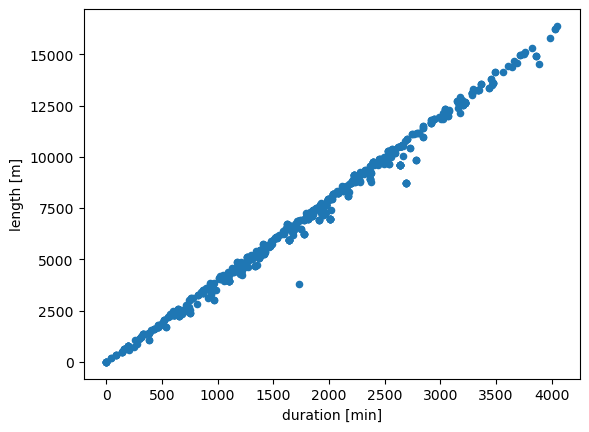

In [446]:
#Plotting the trip length against the duration
plt.figure(figsize=(15, 75))
routing_distances_durations.plot.scatter(x='duration [min]', y='length [m]')

The duration-length scatterplot shows that that two columns have a very good positive correlation.

In [447]:
# sorting the values by hour
routing_distances_durations = routing_distances_durations.sort_values(by=['hour'])

# creating a new dataframe with the means of the duration and length of the trips grouped by the day
routing_distances_durations1 = routing_distances_durations.groupby(by=['hour']).agg({'duration [min]':'mean', 'length [m]':'mean'}).\
        reset_index()
routing_distances_durations1 = routing_distances_durations1.sort_values(by=['hour'])
routing_distances_durations1['duration [h]'] = (routing_distances_durations['duration [min]']/60).astype(str)
routing_distances_durations1['length [km]'] = routing_distances_durations1['length [m]']/1000
routing_distances_durations1.head()

hour  duration [min]  length [m]        duration [h]  length [km]
0     0          2023.8     7430.20  31.216666666666665      7.43020
1     1           968.5     3584.00               58.15      3.58400
2     2           664.0     2522.00               58.15      2.52200
3     5          2804.0    10194.00  24.166666666666668     10.19400
4     6          1190.6     4678.55  24.166666666666668      4.67855

We converted the duration from minutes to hours and length from meters to kilometers and plotted the trip durations and length per hour. The trips that lasted the longest were the ones made at noon and 1 pm. Surprisingly, the trips that lasted almost as the mentioned ones were the ones made at 1 and 2 am. However, the longest tips happened at 5 am and 10 pm, but the ones at 5 am did not last long, that is maybe due to not many trips were made at that hour and for the analysis, we took the mean of the distance and length per hour so the trips that were 10 or more km long took more minutes, but there was a bunch the ones that took just a few minutes so when we calculated the mean the duration went down. Maybe it would be better if we calculated the median, it would show a better picture.

In [450]:
# Creating a bar chart of the trip durations grouped by the hour of the day

# changing the data type of the hour column to string
routing_distances_durations1['hour'] = routing_distances_durations1['hour'].astype(str)

p = figure(title="Trip duration per hour", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_distances_durations1['hour'].unique())

#defining  the columns for each bar
bar_xy = ["duration [h]"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_distances_durations1, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("duration", '@duration [h]')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

In [451]:
# Creating a bar chart of the trip distances grouped by the hour of the day

p = figure(title="Trip length in km per hour", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_distances_durations1['hour'].unique())

#defining  the columns for each bar
bar_xy = ["length [km]"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_distances_durations1, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("length", '@length [km]')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

We did the same visualizations with the boxplots, but here we left the duration in minutes, and the length in meters.

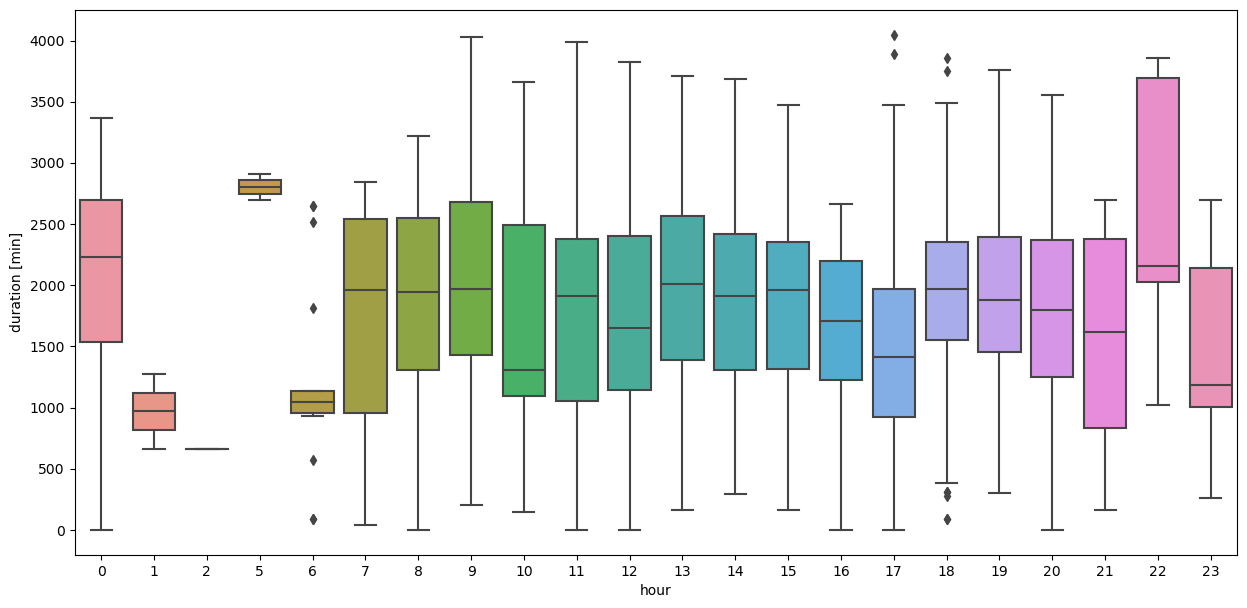

In [452]:
# Creating a boxplot of the trip durations grouped by the hour of the day

plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_distances_durations.columns), 1, counter)
#plt.scatter(routing_distances_durations['hour'],routing_distances_durations['duration [min]'])
sns.boxplot(x=routing_distances_durations['hour'], y=routing_distances_durations['duration [min]'])
counter = counter + 1

In [453]:
# creating a new dataframe with the means of the duration and length of the trips grouped by the month
routing_distances_durations1m = routing_distances_durations.groupby(by=['month']).agg({'duration [min]':'mean', 'length [m]':'mean'}).\
        reset_index()
routing_distances_durations1m = routing_distances_durations1m.sort_values(by=['month'])
routing_distances_durations1m['duration'] = (routing_distances_durations['duration [min]']/60).astype(str)
routing_distances_durations1m['length'] = (routing_distances_durations1m['length [m]']/1000).astype(str)
routing_distances_durations1m.head()

month  duration [min]   length [m]            duration              length
0      1     1792.951735  6975.117647  31.216666666666665   6.975117647058823
1     10     2116.259259  8349.333333               58.15   8.349333333333334
2     11     1718.076923  6700.884615               58.15  6.7008846153846156
3     12     1913.172414  7549.327586  24.166666666666668   7.549327586206897

In [454]:
# Creating a bar chart of the trip durations grouped by the month

# changing the data type of the hour column to string
routing_distances_durations1m['month'] = routing_distances_durations1m['month'].astype(str)

# plotting
p = figure(title="Trip duration in hours per month", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_distances_durations1m['month'].unique())

#defining  the columns for each bar
bar_xy = ["duration"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='month', top=i, bottom=0, width=0.5, source = routing_distances_durations1m, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("month", "@month"),
    ("duration", '@duration')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

In [456]:
# Creating a bar chart of the trip distances grouped by the hour of the month

# plotting
p = figure(title="Trip length in km per month", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_distances_durations1m['month'].unique())

#defining  the columns for each bar
bar_xy = ["length"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='month', top=i, bottom=0, width=0.5, source = routing_distances_durations1m, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("month", "@month"),
    ("length", '@length')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

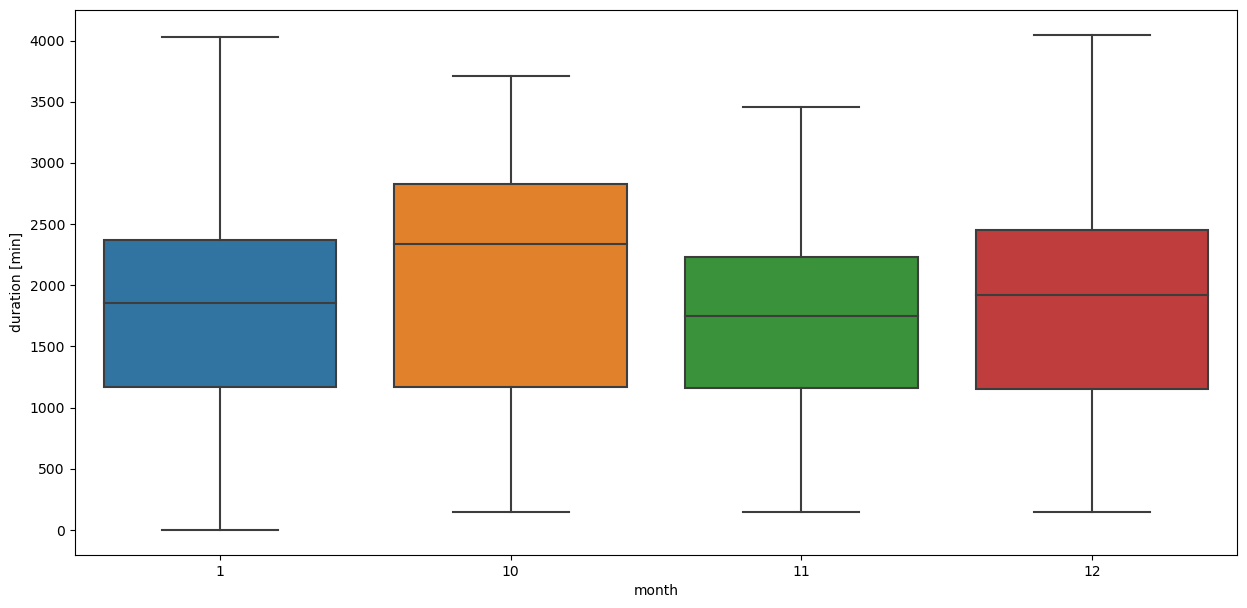

In [457]:
# Creating a boxplot of the trip durations grouped by the month

plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_distances_durations.columns), 1, counter)
#plt.scatter(routing_distances_durations['hour'],routing_distances_durations['duration [min]'])
sns.boxplot(x=routing_distances_durations['month'], y=routing_distances_durations['duration [min]'])
counter = counter + 1

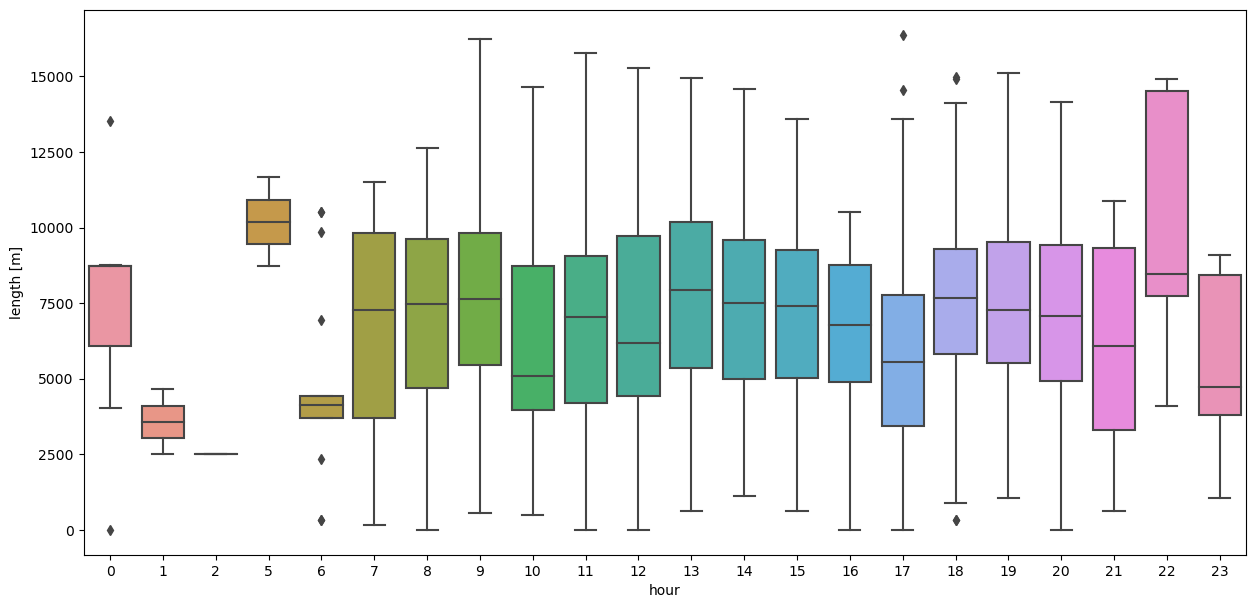

In [458]:
# Creating a boxplot of the trip distances grouped by the hour of the day

plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_distances_durations.columns), 1, counter)
#plt.scatter(routing_distances_durations['hour'],routing_distances_durations['duration [min]'])
sns.boxplot(x=routing_distances_durations['hour'], y=routing_distances_durations['length [m]'])
counter = counter + 1

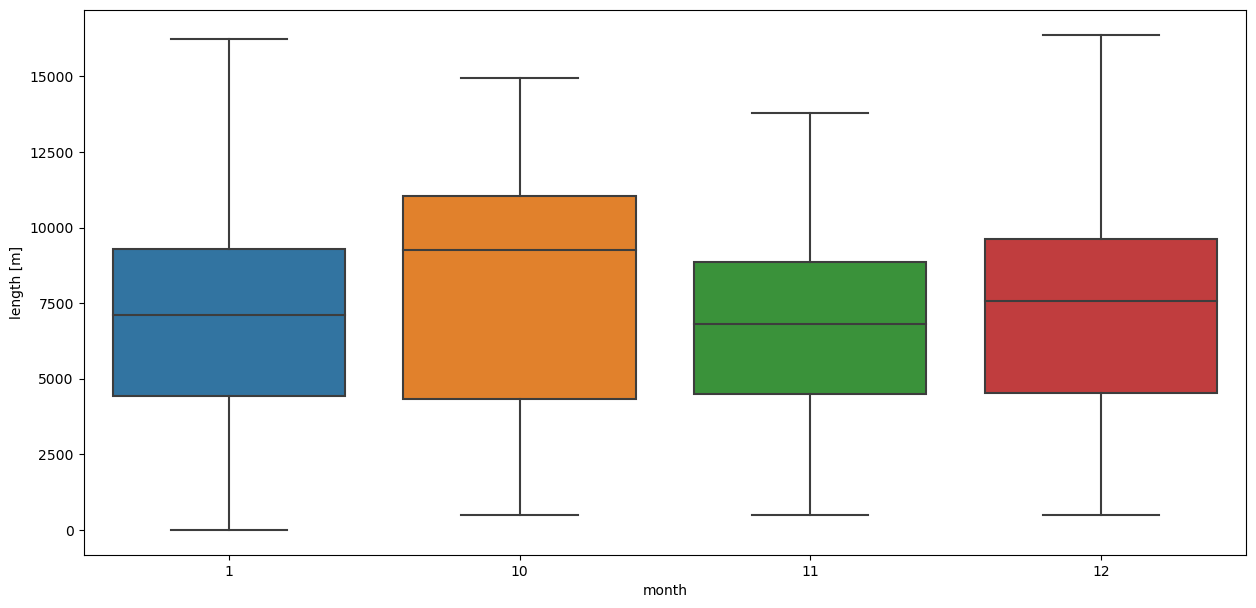

In [459]:
# Creating a boxplot of the trip distances grouped by the month

plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_distances_durations.columns), 1, counter)
#plt.scatter(routing_distances_durations['hour'],routing_distances_durations['duration [min]'])
sns.boxplot(x=routing_distances_durations['month'], y=routing_distances_durations['length [m]'])
counter = counter + 1

In [465]:
# count the amount of trips during a specific hour

routing_distances_durations_count = routing_distances_durations.groupby(by=['hour']).agg({'date':'count'}).\
        rename(columns={'date':'count'}).reset_index()
# routing_distances_durations_count = routing_distances_durations_count.rename(columns={'duration [min]':'duration','length [m]':'length'})
# routing_distances_durations_count['duration'] = (routing_distances_durations_count['duration']/60).mean()
# routing_distances_durations_count['length'] = (routing_distances_durations_count['length']/1000).mean()
# routing_distances_durations_count['hour'] = routing_distances_durations_count['hour'].astype(str)
# routing_distances_durations_count['duration'] = routing_distances_durations_count['duration'].astype(str)
# routing_distances_durations_count['length'] = routing_distances_durations_count['length'].astype(str)
routing_distances_durations_count.head()


hour  count
0     0     10
1     1      2
2     2      1
3     5      2
4     6     20

This plot shows the number of trips during a specific hour.

In [467]:
# plotting
p = figure(title="Trips per hour", width=500, height=500, tools='hover', toolbar_location=None)

#defining  the columns for each bar
bar_xy = ["count"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_distances_durations_count, legend_label=i)
    items.append((i,[bar[i]]))

p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("count", "@count")
    ]))


show(p)
output_notebook()

Loading BokehJS ...

# Weather analysis

It was easy to see that the weather is the single most impactful factor on the load the bike-sharing system will experience. Even with just plotting the data, one can see that the rental numbers essentially follow the seasons, just like the temperature. Nevertheless, the analysis was conducted as follows:

Firstly, the preprocessed data needed a little more care, and a few days were missing from one dataset compared to the other. So I compared which days were only present in only one of the datasets and removed it. 


In [103]:
#match times of the weather and bike rental data: bike rental starts from 2010 07 30 and finishes at 2022 01 31.
#while the weather data starts at: 2010 01 01 and finishes at 2019 12 31
#so we start with cutting the first half year of the weather data.
weatherCut = weather.loc[weather['ob_time'] >= dt.strptime("2010 7 30", "%Y %m %d" )]
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentals.loc[bike_rentals['Day'] < dt.strptime("2020 1 1", "%Y %m %d" )]
#it appears to be that there is more bike rental data than weather by 12.
print(len(weatherCut))
type(bike_rentalsCut)

3430


pandas.core.frame.DataFrame

In [104]:
#we find any piece of data that does not exist in the other dataframe. 
#we find missing data in weather data but not the other way around
missingTimes = []
for time in bike_rentalsCut['Day']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(weatherCut['ob_time'].isin(listLikeObject).any().any()):
        print('value does not exist in weatherCut', time)
        missingTimes.append(time)
        
for time in weatherCut['ob_time']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(bike_rentalsCut['Day'].isin(listLikeObject).any().any()):
        print('value does not exist in bike_rentalsCut', time)

value does not exist in weatherCut 2013-05-08 00:00:00
value does not exist in weatherCut 2013-05-10 00:00:00
value does not exist in weatherCut 2013-05-11 00:00:00
value does not exist in weatherCut 2013-05-12 00:00:00
value does not exist in weatherCut 2013-05-13 00:00:00
value does not exist in weatherCut 2014-06-10 00:00:00
value does not exist in weatherCut 2014-06-11 00:00:00
value does not exist in weatherCut 2014-06-12 00:00:00
value does not exist in weatherCut 2014-06-13 00:00:00
value does not exist in weatherCut 2014-06-14 00:00:00
value does not exist in weatherCut 2014-06-15 00:00:00
value does not exist in weatherCut 2019-05-21 00:00:00


In [105]:
#then we remove the missing days from the bike rental data
dropindices = []
for missingTime in missingTimes:
    dropindices.append(bike_rentalsCut[bike_rentalsCut['Day'] == missingTime].index[0])

bike_rentalsCut = bike_rentalsCut.drop(index = dropindices)
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentalsCut.reset_index()
#now we see that the dates are synced up. 
print(len(weatherCut))
print(len(bike_rentalsCut))

3430
3430


In [106]:
#rename columns to have the same name
weatherCut.rename(columns = {'ob_time':'Day'}, inplace = True)

#merge the dataframes
weatherJoined = pd.merge(weatherCut, bike_rentalsCut, on = "Day", how = "inner")

#drop not needed columns
weatherJoined.drop('index_x',axis=1, inplace = True)
weatherJoined.drop('level_0',axis=1, inplace = True)
weatherJoined.drop('index_y',axis=1, inplace = True)

#drop NAN values
weatherJoined.dropna(inplace=True)

Then, a correlation matrix was made to get a feel for the data and how it works. Here the values like 0.64 (temperature), -0.55 (humidity), and 0.54 (sunshine rate in a day) hint at the nature of the data. 

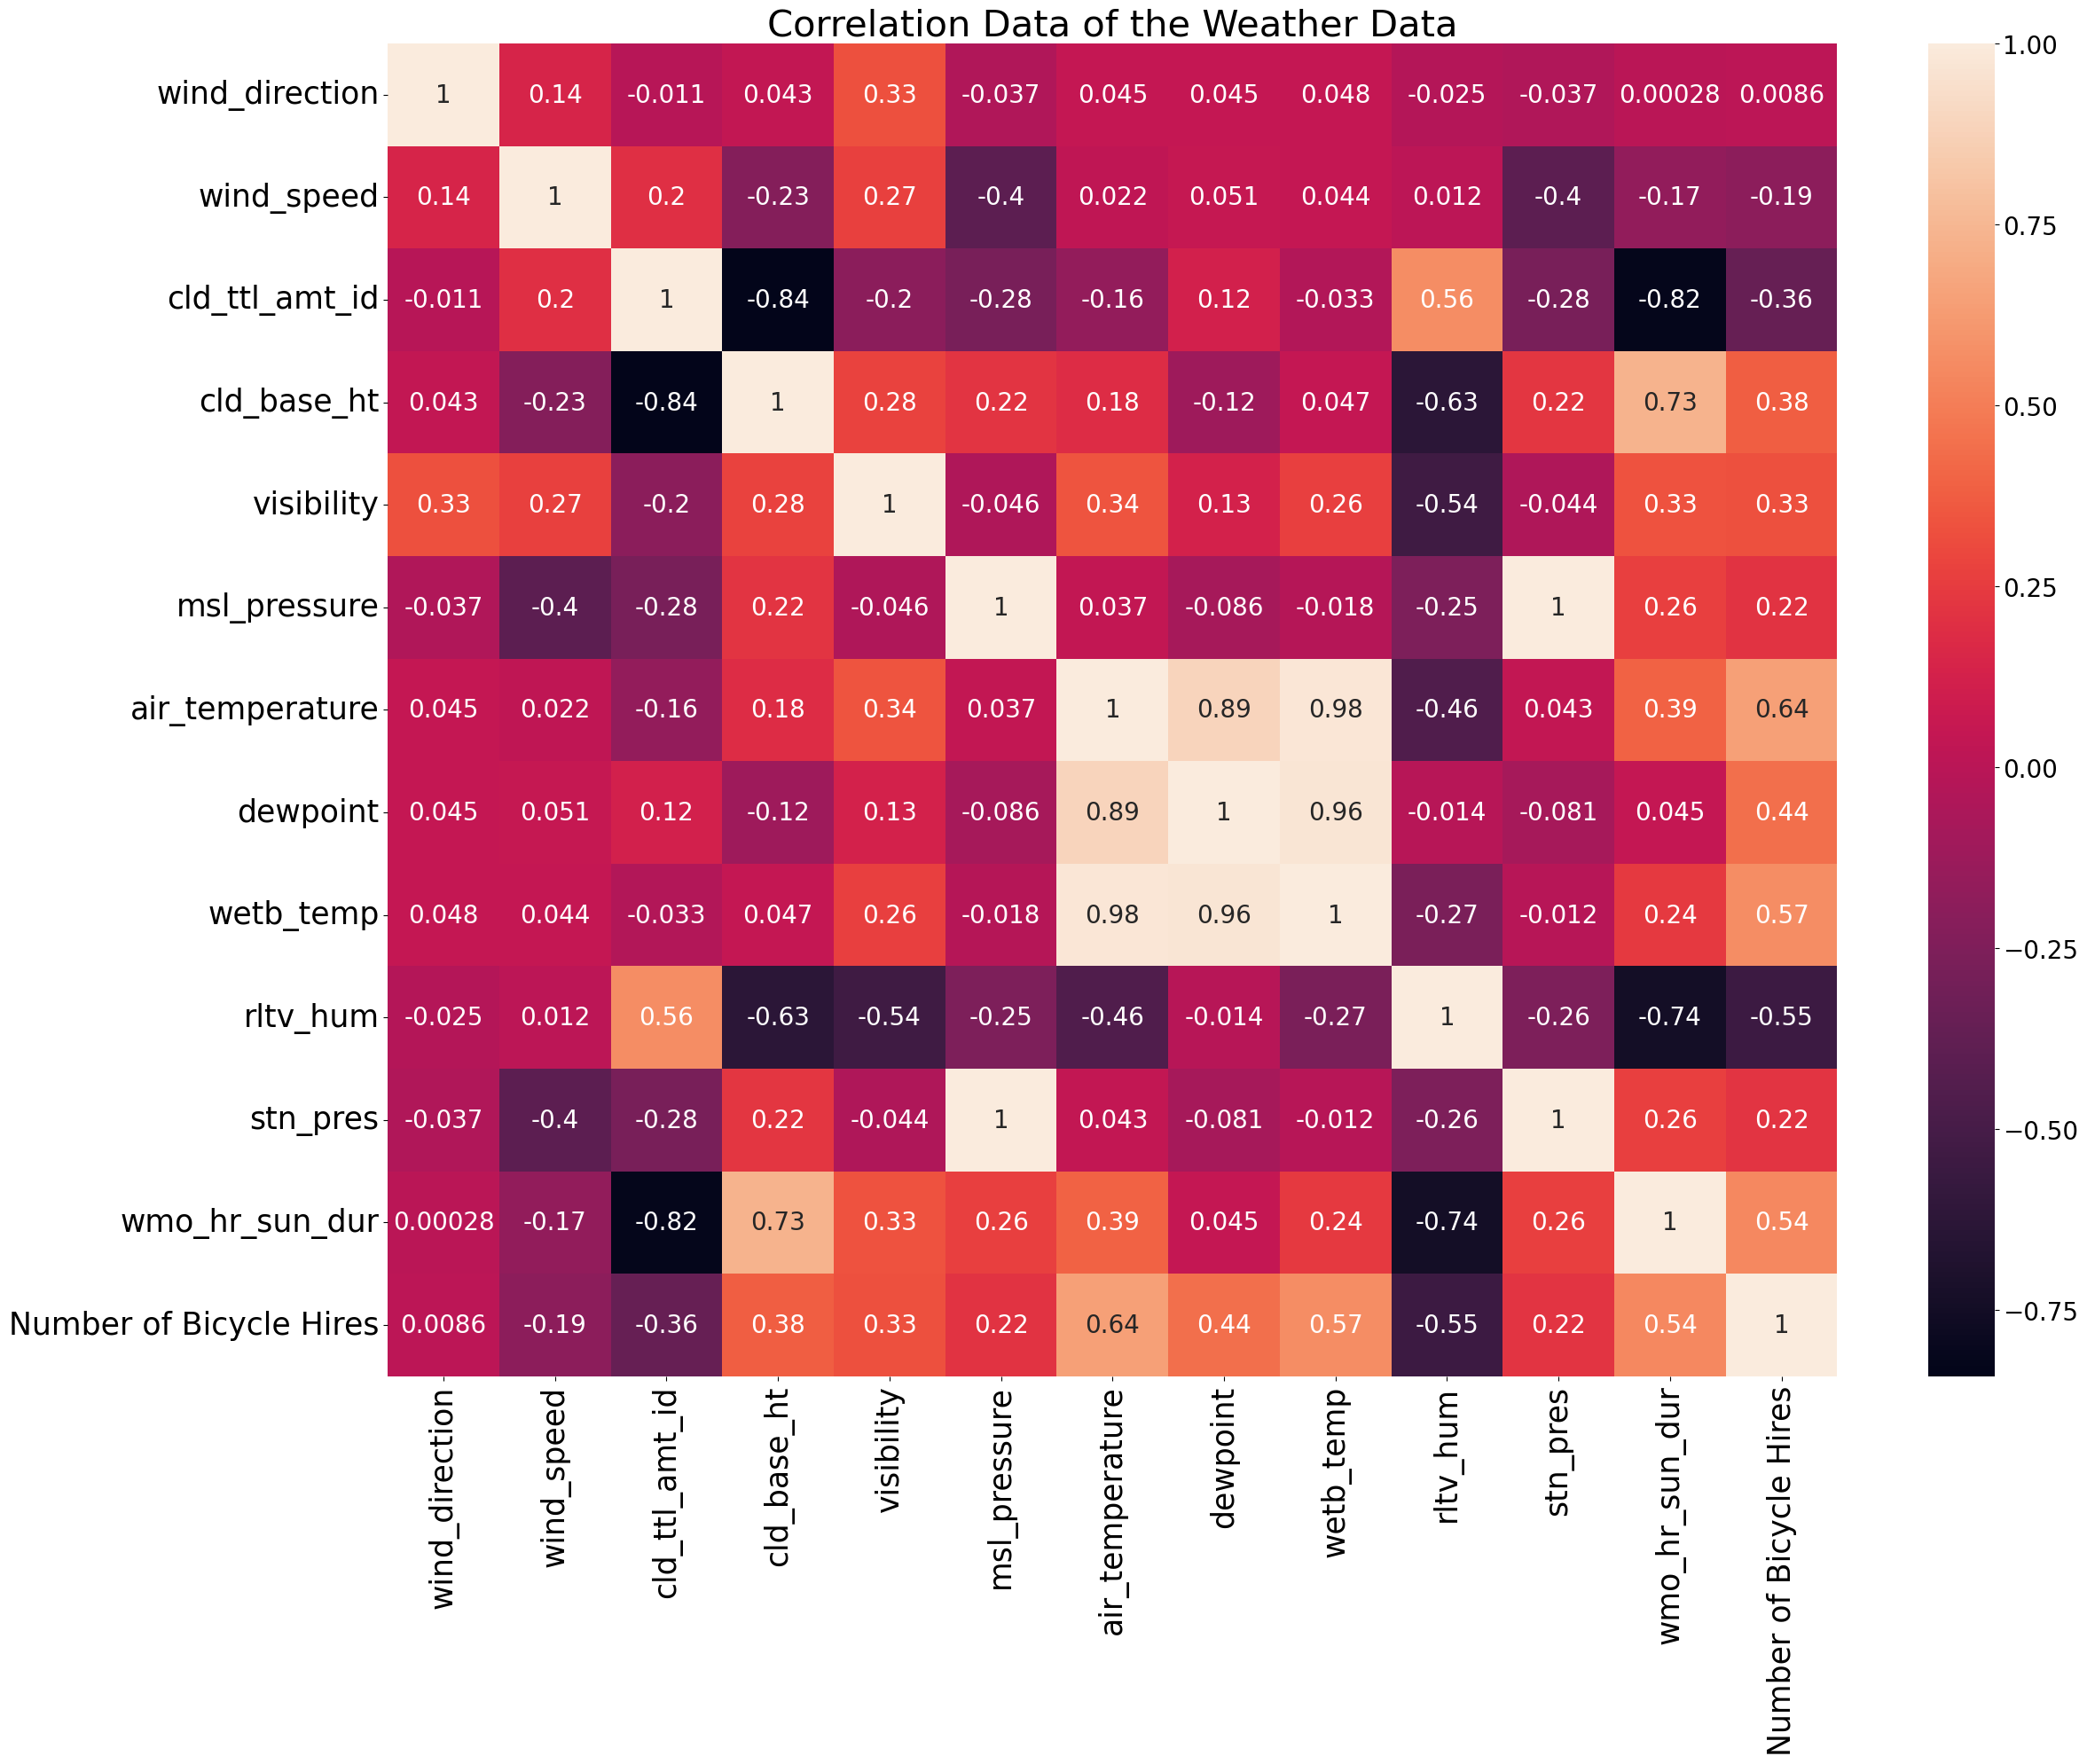

In [107]:
corrMatrix = weatherJoined.corr()
plt.figure(figsize=(25, 20))
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 20})
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.title('Correlation Data of the Weather Data', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

Then, to confirm this, each variable was plotted against the date value as a line plot. Here the seasonal nature of the bike rentals was confirmed. 

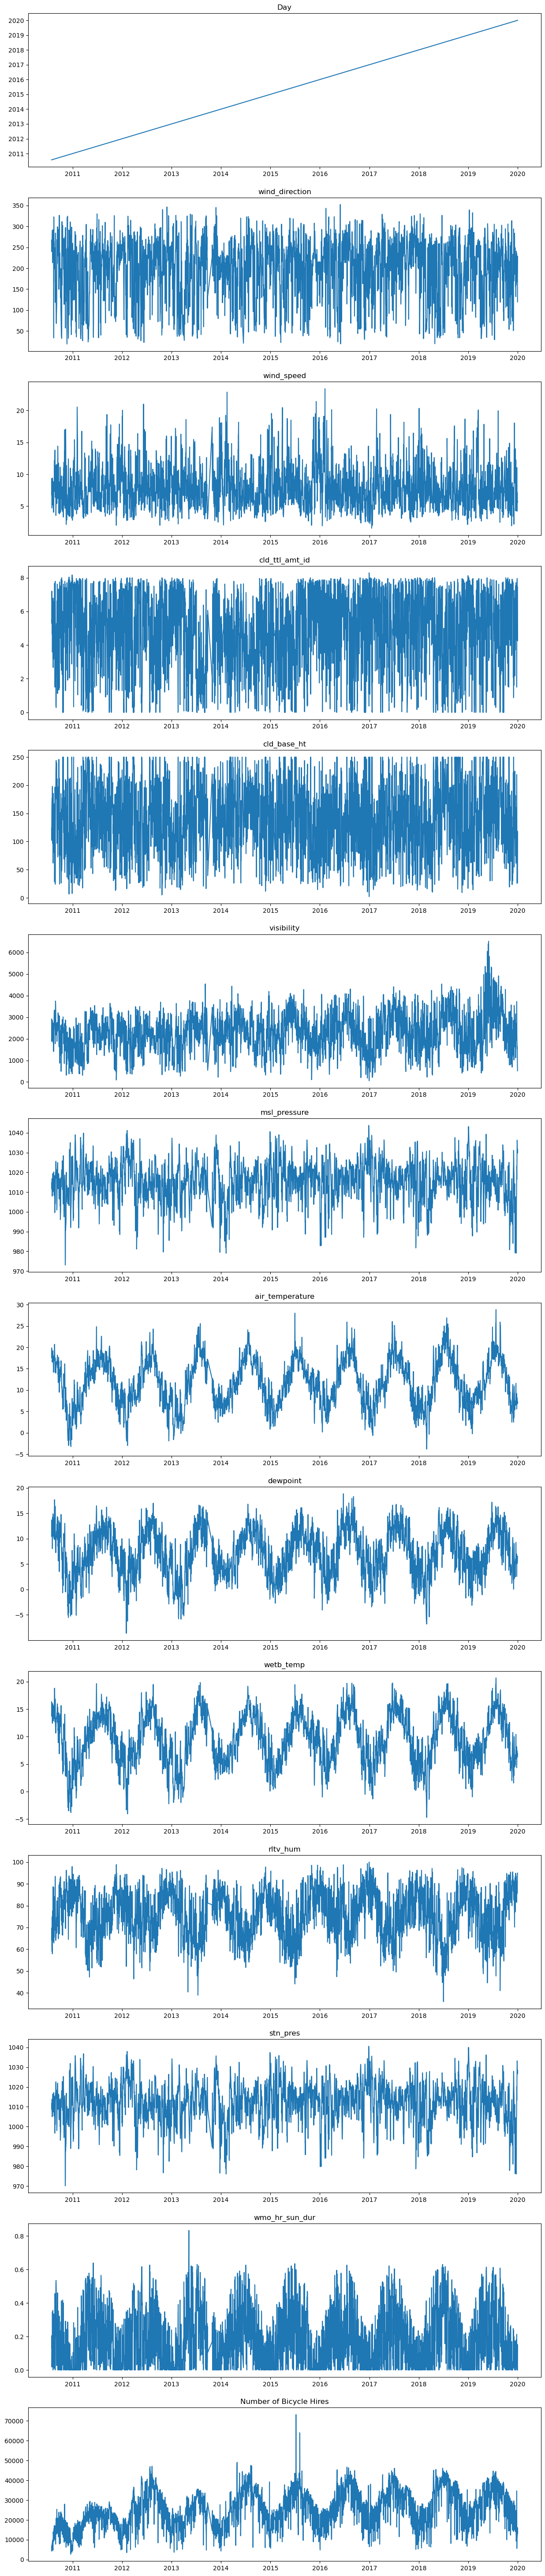

In [108]:
#plot everything compared to day, to get a feel how the variables change over time. 
plt.figure(figsize=(15, 75))
counter = 1
for col in weatherJoined.columns:
    ax = plt.subplot(len(weatherJoined.columns), 1, counter)
    ax.set_title(col)
    plt.plot(weatherJoined['Day'], weatherJoined[col])
    counter = counter + 1

Next step was to bin the weather values into 5 different bins: 0-20%, 20-40%, 40-60%, 60-80%, 80-100% of the maximum value. Then for these five bins, a boxplot was created for each variable on the bike rental numbers to see the data distribution. There were very few outliers compared to a dataset of this size. Moreover, the correlation between weather values and bike rental numbers was also visible. If it was positively correlating, the higher value bins would tend to have higher rental numbers, and the opposite effect was seen on negatively correlating features. 


In [109]:
# now we will try to bin for each variable, then make boxplots to see how it affects the rental numbers.
counter = 1

weatherBinned = pd.DataFrame(weatherJoined['Number of Bicycle Hires'])
for col in weatherJoined.columns:
    binColTitle = col + ' binned'
    bins = [weatherJoined[col].min(),
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.2,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.4,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.6,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.8, 
            weatherJoined[col].max()]
    labels = ['Lowest', 'Low', 'Medium', 'High', 'Highest']
    weatherBinned[binColTitle] = pd.cut(weatherJoined[col], bins, include_lowest = True, labels = labels)
    counter = counter + 1

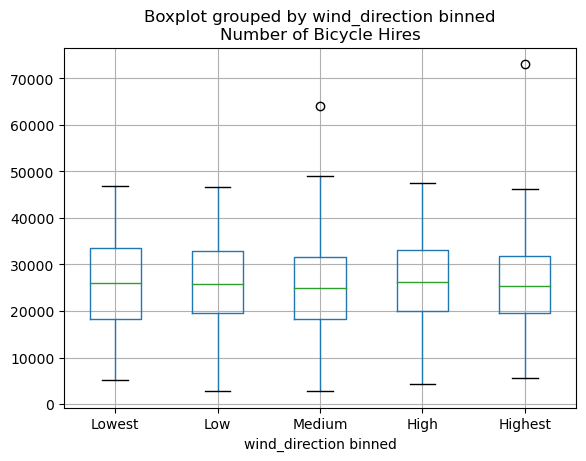

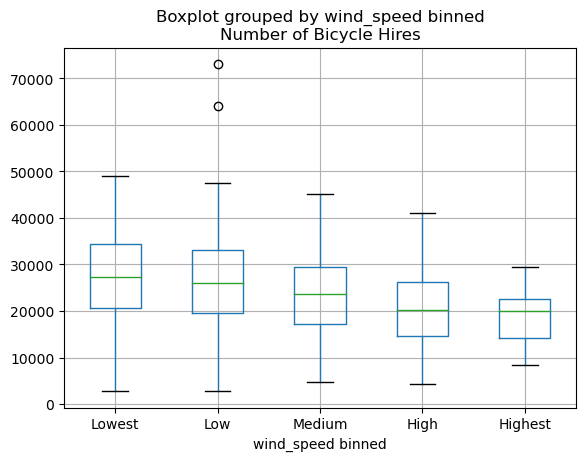

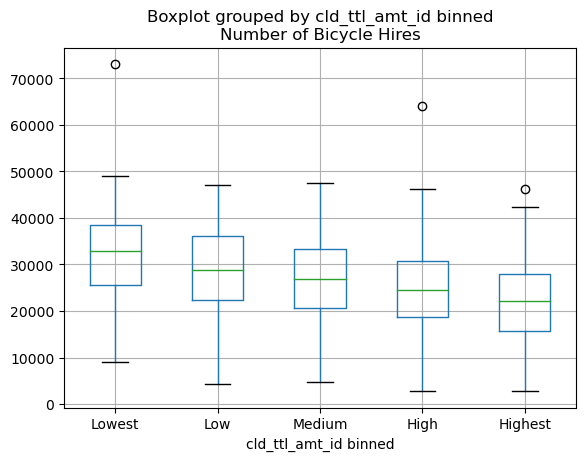

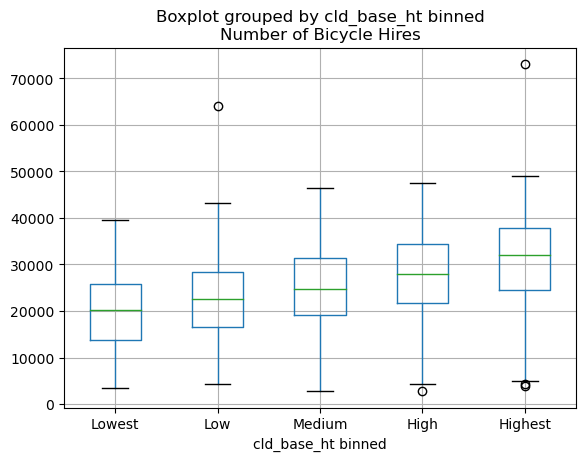

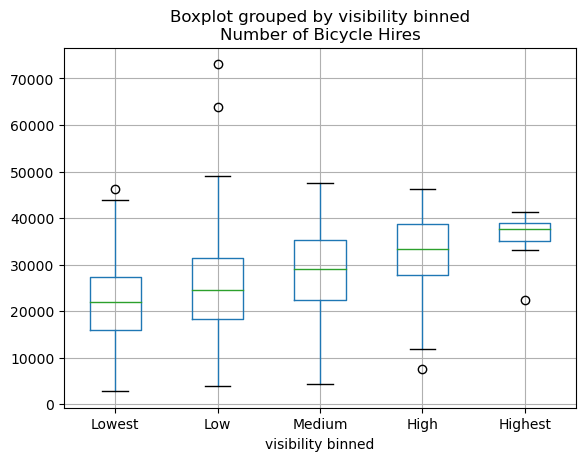

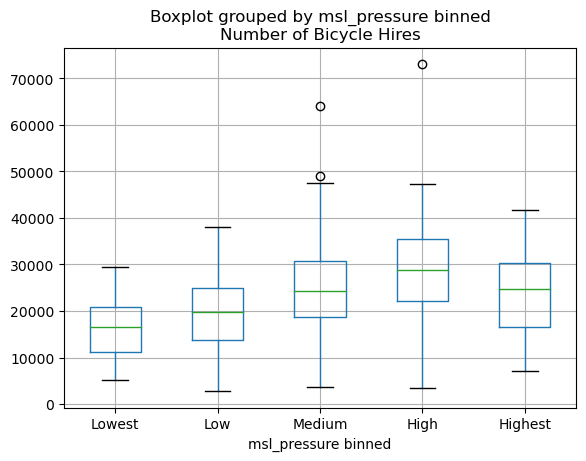

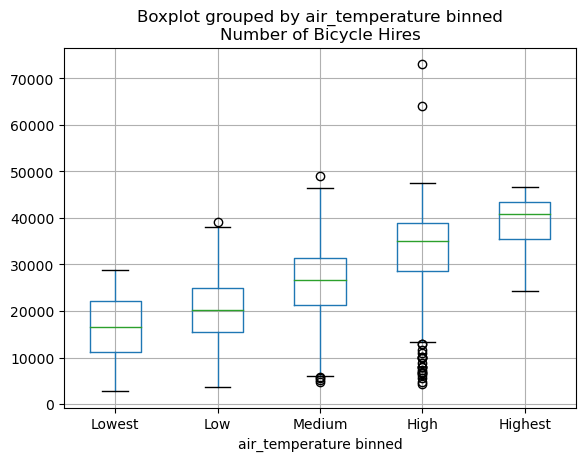

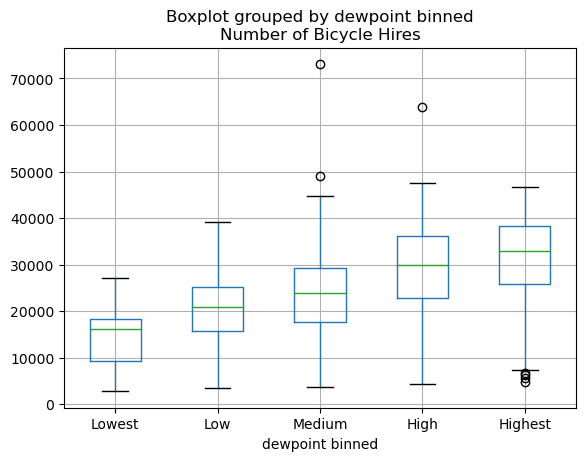

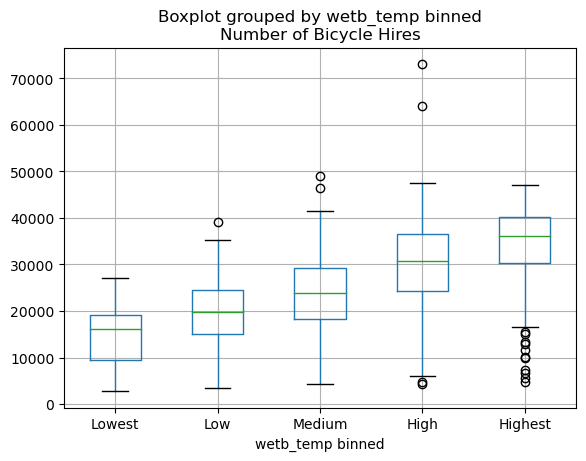

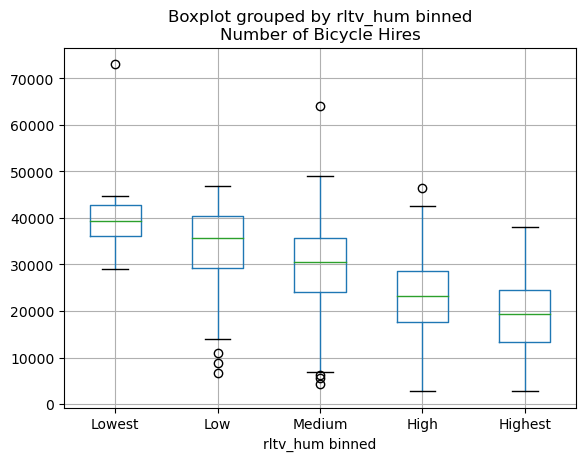

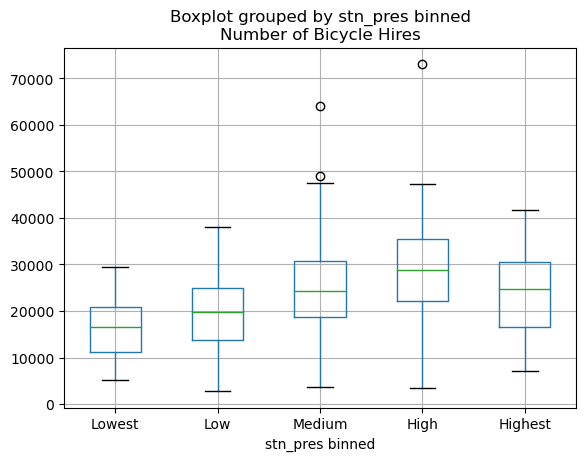

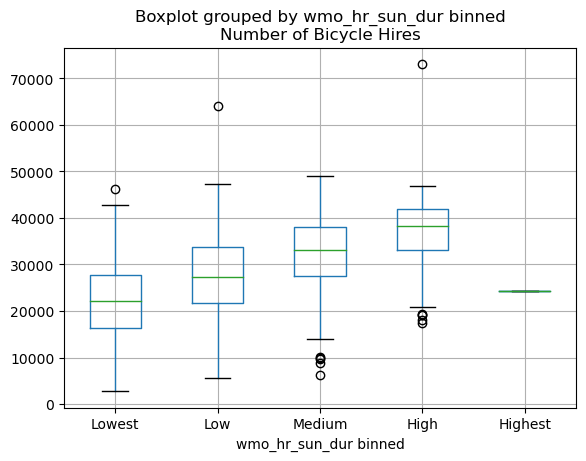

In [110]:
# generate boxplots

for col in weatherBinned.columns:
    if(col == 'Number of Bicycle Hires' or col == 'Day binned' or col == 'Number of Bicycle Hires binned'):
        continue
    weatherBinned.boxplot('Number of Bicycle Hires', col)


In [424]:
# make specific bokeh plots that are actually used in the website: hires per day.

output_file('numberOfHiresPerDay.html')
fig = figure(title = 'Bicycle hires day by day', x_axis_label = 'Date', y_axis_label = 'Bicycle hires', x_axis_type='datetime', plot_width=475, plot_height=190)
fig.line(weatherJoined['Day'],weatherJoined['Number of Bicycle Hires'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('Number of Bicycle hires', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

In [426]:
# make specific bokeh plots that are actually used in the website: temperatures per day.

output_file('temperaturePerDay.html')
fig = figure(title = 'Temperatures day by day', x_axis_label = 'Date', y_axis_label = 'Temperature', x_axis_type='datetime', plot_width=475, plot_height=190)
fig.line(weatherJoined['Day'],weatherJoined['air_temperature'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('temperature', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

It was here that I thought these plots could explain the relationship between bike rental numbers and features of the weather to a general audience on the website. I chose to use the line plots of rental numbers and temperatures and let the user see how similar they are (hinting at correlation). I decided against using boxplots on the website as I do not believe it contains readily digestible information for the general audience.  

# Machine Learning Model to predict Bike-Sharing Demand

In [ ]:
# inspiration:
# notebook: https://github.com/shayanalibhatti/Predicting_Bike_Share_Demand_with_LSTM/blob/master/Bike_Share_Prediction_Code.ipynb
# articel: https://medium.com/analytics-vidhya/capital-bike-share-demand-prediction-using-machine-learning-3c6c2c958e82

The idea was to predict the demand for bike sharing in the future. The data is a time series of the rental numbers, so we chose a Long Short-Term Memory (LSTM) Model as a regular Recurrent Neural Network (RNN) lacks long term memory due to the vanishing gradient effect. We used the weather data and the rental numbers, so we chose a multivariate approach.

In [111]:
bike_rentals.head()

Day  Number of Bicycle Hires
0 2010-07-30                     6897
1 2010-07-31                     5564
2 2010-08-01                     4303
3 2010-08-02                     6642
4 2010-08-03                     7966

In [112]:
bike_rentals.describe()

Number of Bicycle Hires
count              4204.000000
mean              26320.135347
std                9693.146364
min                2764.000000
25%               19271.000000
50%               26145.500000
75%               33371.000000
max               73094.000000

In [114]:
pd.date_range(start = np.min(bike_rentals_weather.index), end = np.max(bike_rentals_weather.index) ).difference(bike_rentals_weather.index)
# missing a few dates


DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')

In [117]:
# LSTM Model

# source
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [242]:
# Preprocessing
bike_rentals_weather = bike_rentals_weather.set_index('Day')
bike_rentals_weather = bike_rentals_weather.dropna()
X, y = bike_rentals_weather, bike_rentals_weather['Number of Bicycle Hires'].values
X.shape, y.shape

((3376, 13), (3376,))

The data is scaled to improve model performance. Feature engineering was not applied as there are no categorical variables. We preprocessed the data in sequences according to the sliding window approach as the network remembers the previous steps, so it is trained with multiple smaller sequences chronologically. We added a drop out layer and L2 regularization to prevent overfitting. The model consists of an LSTM layer, two hidden layers and as activation function, we used the commonly used Rectified Linear Activation Function (ReLu). We asse our training and testing loss using the well-known Mean-Squared Error (MSE).

In [244]:
# Feature Scaling
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [337]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 1500, 500) # based the last 1500 predict the next 500
print(X_ss.shape, y_mm.shape)

(1378, 1500, 13) (1378, 500)


In [338]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
test_size = round((bike_rentals_weather.shape[0]*0.2))

X_train = X_ss[:-test_size]
X_test = X_ss[-test_size:]

y_train = y_mm[:-test_size]
y_test = y_mm[-test_size:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (703, 1500, 13) (703, 500)
Testing Shape: (675, 1500, 13) (675, 500)


In [339]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [340]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 1500, # n_steps_in
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 1500, # n_steps_in
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([703, 1500, 13]) torch.Size([703, 500])
Testing Shape: torch.Size([675, 1500, 13]) torch.Size([675, 500])


In [341]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [342]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [509]:
n_epochs = 100 # 1000 epochs # 100 seems good
learning_rate = 0.001 # 0.001 lr

input_size = 13 # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 500 # number of output classes # n_steps_out

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [510]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay= 1e-4) 


training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.15948, test loss: 0.15927
Epoch: 10, train loss: 0.07331, test loss: 0.07378
Epoch: 20, train loss: 0.03066, test loss: 0.03231
Epoch: 30, train loss: 0.01945, test loss: 0.02167
Epoch: 40, train loss: 0.01623, test loss: 0.01846
Epoch: 50, train loss: 0.01485, test loss: 0.01743
Epoch: 60, train loss: 0.01410, test loss: 0.01666
Epoch: 70, train loss: 0.01337, test loss: 0.01576
Epoch: 80, train loss: 0.01263, test loss: 0.01499
Epoch: 90, train loss: 0.01190, test loss: 0.01436


We optimize the parameters of the network using the Adam optimizer. We input all our features and applied a rule of thumb for the amount hidden neurons, which suggest using roughly two thirds of the amount of input features. After a couple test runs the 100 epochs seemed sufficient to predict 500 values as the loss starts to stagnate. A learning rate of 0.001 seemed to archive good results. 

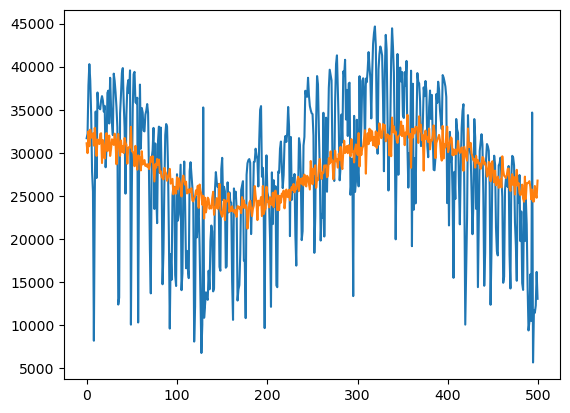

In [511]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

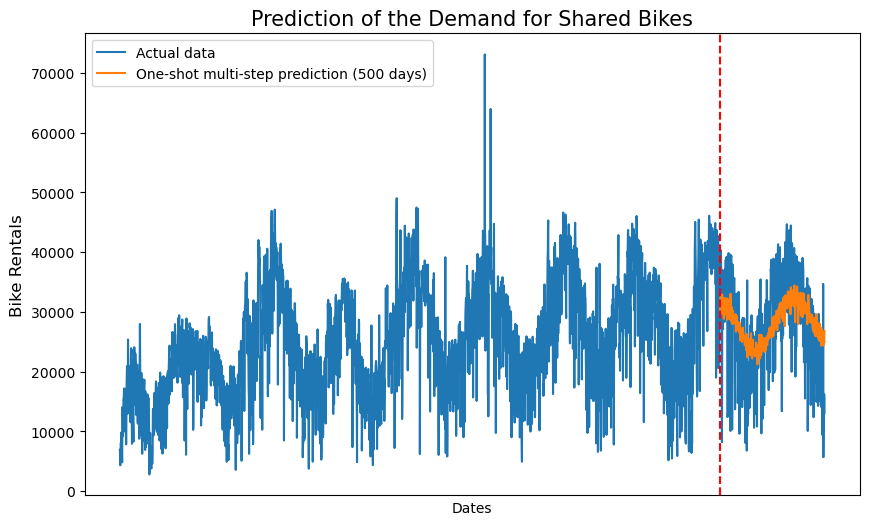

In [525]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(y, label='Actual data');
c = [x for x in range(len(y)-500, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (500 days)')
plt.axvline(x=len(y)-500, c='r', linestyle='--')
plt.title('Prediction of the Demand for Shared Bikes', fontsize = 15)
plt.xlabel('Dates')
plt.xticks([])
plt.ylabel('Bike Rentals', fontsize= 12)
plt.legend()
plt.show()


# 3. Genre

We have combined the elements of the annotated chart with the slideshow genre. While our slides are all about bike rentals in London, each slide discovers a different perspective for it. The different aspects are cast into different slides, wherein these slides with a variety of visualization types (line plot, bar chart, map), we discover and explain the given subtopic. 

Even though we mentioned that we would use the structure "Martini glass" in our video, we decided to use the structure "Interactive slideshow". We wanted to accommodate the chosen combination of genres and we thought that regardless of how the topics follow each other, each should have the right amount of interaction.


The tools we used from each of the 3 categories of Visual Narrative:
1) Visual structuring 
    - Consistent visual platform 
    - Progress bar 

2) Highlighting 
   - Feature distinction 
   - Size of maps 
   - Difference and color of plots 

3) Transition guidance 
   - Slideshow 
   
When a viewer opens our website, the first thing that becomes apparent is the map (once it is loaded, that is). In itself, it does not direct the attention to our topic as a splash screen would, but the surrounding text information quickly establishes the context of our story (we are in London, we look at bike rental data, and that it is from 2010-2022) and the scale of it (how much of bike renting is happening). As the viewer progresses through our slideshow, the viewer will find that many elements are either in a consistent location or style. Also, the progression of the viewer can be tracked in the bottom of the page, where the current slide is highlighted, and any individual slide can be chosen to view. 

There are two main factors directing the viewer's attention: the size of the visualizations and its colors. The size is the most apparent for the maps, while the colors on the visualizations break from the black-and-white nature of the slideshow. In other cases, such as the bar chart, the coloring even carries information, as it helps to distinguish between positive (green) and negative (red) effects.

The transition between the slides is guided by the arrows always present in each side of the screen. The slideshow format guarantees a familiar format for the viewer, knowing where to expect the next slide, and the previous slide.

The tools we used from each of the 3 categories of Narrative Structure:

1) Ordering 
    - Linear (author directed) or user chosen (select random slide)  

2) Interactivity 
    - In many cases there are details on demand 
    - Scrollable, zoomable map, that concatenates information not to be overwhelming.  
    - Navigation buttons  
    - Explicit instruction 

3) Messaging 

    - Multi messaging: All different slides explain a different perspective on bike rentals. 
    - Captions 
    - Annotations (graph titles) 
    - Comment repetition. (Repetition of concepts with text and graphs)  

The viewer's path through the website would mostly be linear (user is encouraged to click on the arrows to the left and right sides). However, the user also has the option to switch to any slide. So, the ordering can be a mix of linear and user choice.  

Traversed by navigation arrows, the viewer will find various plots and maps on most of the slides that contain various amounts of interactivity. Almost every plot has more information on demand, and the maps are scroll and zoomable. The first map also concatenates information when zoomed out so that it does not get overwhelming.  

The website's task lets the user view London's bike rental program from different perspectives. Various elements have different roles within the website. Captions introduce topics, while the plots, maps, and text explain said topics. Several topics are also often discussed by text and visualizations, giving the user different avenues to grasp the topics.

# 4. Visualization

The website follows the course's mentality, which dictates that data and derived visualizations are a tool to tell stories. So, whenever possible, we tried to minimize the amount of text we write on the website and let the visualizations do the heavy lifting in telling the story and its context. As we have time-series data, line plots were a central tool on our website.

For example, when designing the website, we had the general audience in mind, and we decided against showing only numbers as a correlation. (look, the correlation between the number of bike rentals and humidity is –0.55! This is not the digestible information that we are looking for) Instead, we plotted two graphs over time, one for temperature and one for the bike rental. Both graphs follow a near sinusoidal pattern as the seasons change, and we let the data tell the users this. Moreover, we added a barchart detailing correlations of other weather phenomena only after this. A bar chart is ideal for representing these categorical values, and the added benefit is that positively and negatively correlating weather effects bars could be colored accordingly (green and red). 

Other times, the focus shifted from the timely nature of the data to more geographical, and maps were created. We use the maps to describe where the stations are, how many are there, and the most popular routes that these bikes take.  

# 5. Discussion

What went well?

The idea was straightforward; it naturally gave the following steps, next plots and ideas. The team worked well together, assigning and completing tasks in an orderly manner. The website conveys a fair bit of information interactively in a more compact space. The course's aim to package up and pass on complex thoughts in different forms of visualizations is reflected on the website.  

What is still missing? What could be improved? Why?

The website certainly needs the loving touch of a designer. As we are no machine learning experts, the model could be tweaked even further and for example, a hyperparameter search could be added. It would also be interesting to visualize trips grouped by weekdays or hour of the day to analyze patterns.  

# 6. Contributions 

Lana Bukovac: s210355 

Philipp Otter: s217102 

Levente Szekely: s210157 

Pre processing: Philipp 

Weather analysis: Levente 

Covid analysis: Lana 

Explainer notebook: all 

Website: Levente 

Geographic analysis: Philipp 

Analyzing trip distances and durations: Lana 

Machine learning and predictions: Philipp 